In [1]:
import os
import numpy as np
import pandas as pd

# Matching
from sklearn.neighbors import NearestNeighbors
import networkx as nx

# Statical analysis
from sklearn.linear_model import LinearRegression
from scipy.stats import chi2_contingency
import scipy.stats as st

# Ploting
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio
from IPython.display import display

# Theme for website

In [2]:
pio.templates.default = 'plotly'

In [3]:
# Copy the existing 'plotly_dark' theme
custom_theme = go.layout.Template(pio.templates['none'])

# Your custom settings
custom_bg_color = 'rgb(255, 255, 255)'  # Your custom background color
custom_font = 'Poppins'  # Your custom font

# Update the theme layout
custom_theme.layout.update(
    plot_bgcolor=custom_bg_color,
    paper_bgcolor=custom_bg_color,
    font=dict(family=custom_font, color="black"),
    colorway=['rgb(255, 185, 54)', '#FF6F59', '#4ECDC4', '#C7F464', '#F7FFF7'],
    #margin=dict(t=0, l=0, b=0, r=0),
    xaxis=dict(gridcolor='LightGrey'),
    yaxis=dict(gridcolor='LightGrey'),
)

# Add the custom theme to Plotly's templates
pio.templates['my_custom_dark_theme'] = custom_theme

# Set the custom theme as default
pio.templates.default = 'my_custom_dark_theme'

# Copy the existing 'plotly_dark' theme
custom_theme = go.layout.Template(pio.templates['plotly_dark'])


# Parallel questions
In this notebook, we carry out the study of the parallel questions related to the influence of movies on baby names as listed in 'parallel questions' in the [README](./README.md) file., therefore conducting a global analysis. For consistency in this analysis, we will work mainly with the names that were significantly influenced by the release of a movie as defined previously in the **influence metric computation** in order to try to draw conclusion. The statistical significance level was chosen to be 5% in this analysis.

## Importing preprocessed datasets

In [4]:
folder_processed_data_path = './data/processed_data/'

# Import movie metadata
movie_df = pd.read_csv(os.path.join(folder_processed_data_path, 'movie_df.csv'))
movie_df.set_index(['wiki_ID'], inplace=True)
display(movie_df.sample(2))

# Import character metadata
name_by_movie_df = pd.read_csv(os.path.join(folder_processed_data_path, 'name_by_movie_ordered_pvalue_10_5_df.csv'))
name_by_movie_df.set_index(['wiki_ID'], inplace=True)
display(name_by_movie_df.sample(2))

# Dataset containing movie genre
movie_genres_df = pd.read_csv(os.path.join(folder_processed_data_path, 'movie_genres_df.csv'))
movie_genres_df.set_index(['wiki_ID'], inplace=True)
display(movie_genres_df.sample(2))

,mov_name,year,month,revenue,numVotes,averageRating
wiki_ID,,,,,,
14027011,Silver Jew,2007,NaN,NaN,90,7.3
1971256,Sylvia Scarlett,1935,NaN,497000.0,4423,6.2


,char_words,order,gender,t_stat,p_value,slope_change
wiki_ID,,,,,,
11829180,Claus,NaN,M,-0.533168,0.604522,0.000007
612018,Girl,18.0,F,0.694315,0.501886,-0.000111


,genre
wiki_ID,
4410686,World cinema
12000999,Thriller


The significance level `alpha` is set to 0.05

In [5]:
alpha = 0.05

### Description and implementation of frequently used dataframes throughout the study

First, we need to generate the dataframes that will permit to adress the study questions. To do that, we merge the existing raw dataframes. Here is a list of the principal dataframes that will be used in the notebook

`name_by_movie_df`: dataframe with names, p_value, slope_change

`movie_df`: dataframe with film caracteristics

`movie_genre_df`: dataframe with movie genre

`name_by_movie_aggregate_df`: `name_by_movie_df` + `movie_df`: dataframe with names, p_value, slope change + film caracteristics

`movie_genre_aggregate_df`: `name_by_movie_df`  + `movie_genre_df`: dataframe with names, p_value, slope change + movie genre for each name in a movie

`movie_genre_aggregate_with_years_df`: dataframe with names, p_value, slope change + movie genre for each name in a movie + years

Let's combine the `name_by_movie` and the `movie` dataframes and use it to answer to the paralleles questions.

In [6]:
# add movie info to the character dataframe
name_by_movie_aggregate_df = name_by_movie_df.merge(movie_df, how='left', left_on='wiki_ID', right_on='wiki_ID').copy(deep=True)
display(name_by_movie_aggregate_df.sample(2))

,char_words,order,gender,t_stat,p_value,slope_change,mov_name,year,month,revenue,numVotes,averageRating
wiki_ID,,,,,,,,,,,,
9947055,Alastair,27.0,M,0.535826,0.602745,-0.000051,Razor,2007,11.0,NaN,23931,7.6
23126218,Wild,NaN,M,NaN,NaN,0.000000,Hell's Heroes,1930,1.0,NaN,897,7.2


# Question 1 : Effect of movie's release period of the year

Looking at studies showing that baby conception rates are at the highest in fall or winter season leading to higher birth in the summer, will movies released in summer show the highest correlation with newborn naming?

In order to study this question, we will divide the movies by season of release and then look at the seasonly/monthly proportion of influenced names with respect to all the names considered. Then, we look at the average influence over all the movies for the 4 different seasons.

First, we separate the dataframe into four, one for each season.

In [7]:
# Define season
summer = [6.0, 7.0, 8.0]
fall = [9.0,10.0,11.0]
winter = [12.0,1.0,2.0]
spring = [3.0,4.0,5.0]

# Filter and drop nan values in 'p-value' to not pollute computation of proportion of significant influences
summer_movies_df = name_by_movie_aggregate_df[(name_by_movie_aggregate_df['month'].isin(summer))].dropna(subset=['p_value'])
fall_movies_df = name_by_movie_aggregate_df[(name_by_movie_aggregate_df['month'].isin(fall))].dropna(subset=['p_value'])
winter_movies_df = name_by_movie_aggregate_df[(name_by_movie_aggregate_df['month'].isin(winter))].dropna(subset=['p_value'])
spring_movies_df = name_by_movie_aggregate_df[(name_by_movie_aggregate_df['month'].isin(spring))].dropna(subset=['p_value'])

### Proportion of influenced names during each season

We first compute the proportion of influenced names per season to perform statistical test about their difference.

In [8]:
# Function to compute proportion of significant values and corresponding standard error for confidence interval
def q1_prop_and_ci(data):
    proportion = (data['p_value']<alpha).mean()
    se = st.sem((data['p_value']<alpha).astype(int))

    ci_upper = proportion + 1.96*se
    ci_lower = proportion - 1.96*se
    return pd.Series({
        'proportion': proportion,
        'ci_lower': ci_lower,
        'ci_upper': ci_upper
    })

prop_summer = q1_prop_and_ci(summer_movies_df)
prop_fall = q1_prop_and_ci(fall_movies_df)
prop_winter = q1_prop_and_ci(winter_movies_df)
prop_spring = q1_prop_and_ci(spring_movies_df)

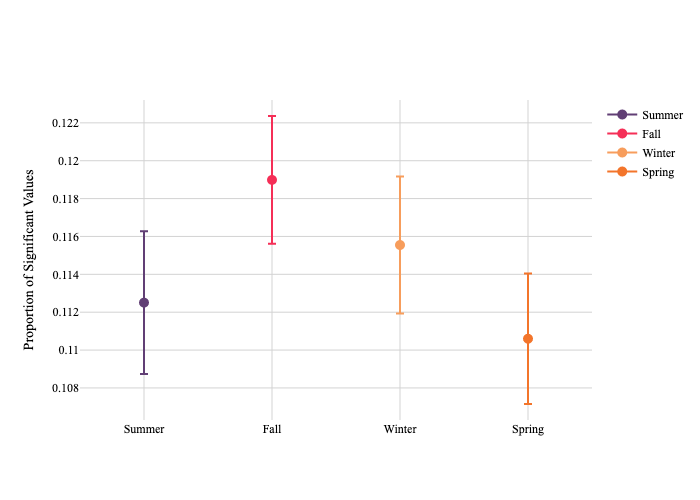

In [9]:
# Create a Plotly figure
fig = go.Figure()

seasons = ['Summer', 'Fall', 'Winter', 'Spring']
colors = ['#613F75', '#F52F57', '#F79D5C', '#F3752B']

# Loop through seasons
for season, color in zip(seasons, colors):
    prop_data = locals()[f'prop_{season.lower()}']  # Access the variable dynamically
    
    # Define y values and error array
    y_values = [prop_data['proportion']]
    error_array = [prop_data['proportion'] - prop_data['ci_lower'], prop_data['ci_upper'] - prop_data['proportion']]
    
    # Add trace to the figure
    fig.add_trace(go.Scatter(
        x=[season],
        y=y_values,
        error_y=dict(type='data', array=error_array),
        mode='markers+lines',
        name=season,
        marker=dict(color=color, size=10)
    ))

# Update layout for better visualization
fig.update_layout(
    yaxis=dict(title='Proportion of Significant Values'),
    # title='Proportion of Significant Values with 95% Confidence Intervals by Season'
)

# Update layout to adjust the range of the x-axis
fig.update_layout(
    xaxis=dict(range=[-0.5, len(prop_data.index) + 1 - 0.5]),  # Adjust the range based on your data
)

fig.update_yaxes(title_standoff=10)

# Show the plot
fig.show(renderer="png")

# Export to html
fig.write_html('q1_proportion_seasons.html', include_plotlyjs="cdn", config={'displayModeBar': False})

Statistical test to assess whether proportion for different season are different or not:

H0 : The proportions are all equal i.e. no movie season release affects baby naming more than the other

In [10]:
# Organize the data into a contingency table
observed_data = [
    [len(summer_movies_df[summer_movies_df['p_value'] < alpha]), len(summer_movies_df['p_value'])],
    [len(fall_movies_df[fall_movies_df['p_value'] < alpha]), len(fall_movies_df['p_value'])],
    [len(winter_movies_df[winter_movies_df['p_value'] < alpha]), len(winter_movies_df['p_value'])],
    [len(spring_movies_df[spring_movies_df['p_value'] < alpha]), len(spring_movies_df['p_value'])]
]

# Perform the chi-squared test
chi2, p, _, _ = chi2_contingency(observed_data)

# Print the results
print("Chi-squared value:", chi2)
print("P-value:", p)

Chi-squared value: 10.4464768641384
P-value: 0.01512840586456576


Since the Chi-squared value is 10.23, we can reject the null hypothesis that the proportion of inlfuenced names are the same between the season at the 5% significance level.

### Proportion of influenced names during each season : timeline

We now try to visualize the variation of the percentage of significantly influenced names per season of release per year. Also, we look at the mean magnitude influence per season over the years with the corresponding 5% confidence interval.

In [11]:
# Compute proportion of significant influence per season per year. 
# Fill nan values with 0 after proportion and ci computation
def seasonal_filter(season_df):
    season_df_sorted = season_df.groupby('year').apply(lambda x: pd.Series({
        'avg': x[x['p_value']<alpha]['slope_change'].dropna().abs().mean(),
        'se': x[x['p_value']<alpha]['slope_change'].dropna().abs().sem(),
        'nb_names':  x[x['p_value']<alpha]['p_value'].count(),
        'prop_influenced': len(x[x['p_value']<alpha])/len(x['p_value'])
    }))
    season_df_sorted.reset_index(inplace=True)
    return season_df_sorted

summer_movies_df_sorted = seasonal_filter(summer_movies_df)
fall_movies_df_sorted = seasonal_filter(fall_movies_df)
winter_movies_df_sorted = seasonal_filter(winter_movies_df)
spring_movies_df_sorted = seasonal_filter(spring_movies_df)

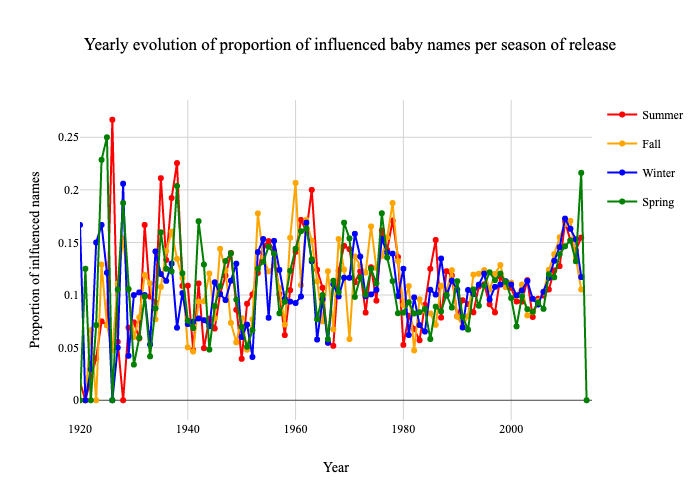

In [12]:
fig = go.Figure()

# Define the main line plot for each season
seasons = ['Summer', 'Fall', 'Winter', 'Spring']
colors = ['red', 'orange', 'blue', 'green']
data = [summer_movies_df_sorted, fall_movies_df_sorted, winter_movies_df_sorted, spring_movies_df_sorted]

for i, season in enumerate(seasons):
    main_trace = go.Scatter(
        x=data[i]['year'],  
        y=data[i]['prop_influenced'],  
        mode='lines+markers',
        line_shape='linear',
        name=season,
        line=dict(color=colors[i]),
        legendgroup=season,
        # visible=(season == 'Summer')
    )
    
    # Add the main line trace to the figure
    fig.add_trace(main_trace)

# Update the layout
fig.update_layout(
    title='Yearly evolution of proportion of influenced baby names per season of release',
    xaxis_title='Year',
    yaxis_title='Proportion of inlfuenced names'
)

fig.update_xaxes(range=['1920', '2015'])
fig.update_yaxes(title_standoff=10)

# Show the figure
fig.show(renderer="png")

From the above plot, it doesn't seem to have big difference between season of movie release. We can now look at monthly variation in proportion to assess whether an eventual effect is more pronounced individually rather than seasonaly.

### Proportion of influenced names during each month : timeline

In [13]:
monthly_prop_df = name_by_movie_aggregate_df.groupby(['year','month']).apply(lambda x: pd.Series({
    'prop_significant': len(x[x['p_value']<alpha])/len(x['p_value'])
}))
monthly_prop_df_reset = monthly_prop_df.reset_index()
display(monthly_prop_df)

prop_significant
year month                  
1895 8.0            0.000000
1898 7.0            0.000000
1900 11.0           0.000000
1902 9.0            0.000000
1903 1.0            0.000000
...                      ...
2013 8.0            0.176471
     9.0            0.111111
     10.0           0.038462
     11.0           0.200000
2014 3.0            0.000000

[1199 rows x 1 columns]

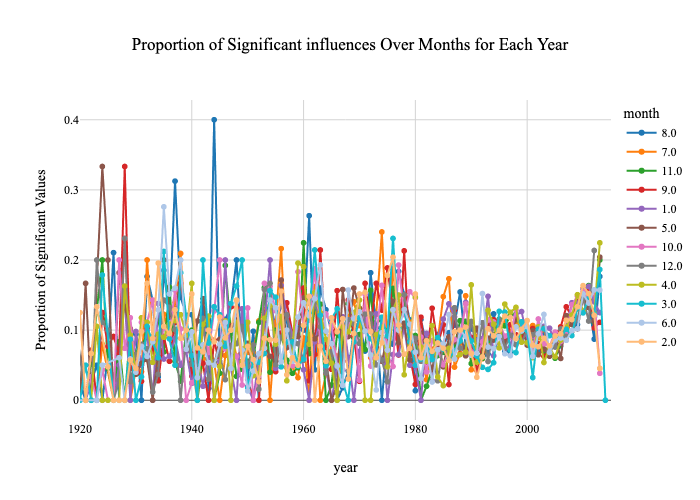

In [14]:
# Convert 'month' column to numeric
monthly_prop_df_reset['month'] = pd.to_numeric(monthly_prop_df_reset['month'], errors='coerce')

colors = [
    '#1f77b4',  # Blue
    '#ff7f0e',  # Orange
    '#2ca02c',  # Green
    '#d62728',  # Red
    '#9467bd',  # Purple
    '#8c564b',  # Brown
    '#e377c2',  # Pink
    '#7f7f7f',  # Gray
    '#bcbd22',  # Olive
    '#17becf',  # Cyan
    '#aec7e8',  # Light Blue
    '#ffbb78'   # Light Orange
]

# Create a line plot using Plotly
fig = px.line(
    monthly_prop_df_reset,
    x='year',
    y='prop_significant',
    color='month',
    markers=True,
    line_shape='linear', 
    labels={'prop_significant': 'Proportion of Significant Values'},
    title='Proportion of Significant influences Over Months for Each Year',
    color_discrete_sequence=colors
)

fig.update_xaxes(range=['1920', '2015'])

fig.update_yaxes(title_standoff=10)

# Show the plot
fig.show(renderer="png")

### Number of influenced names during each season : timeline 

The yearly variation of the number of influenced names per season can be used as a first way to try to quantify the influence of movie release. We then show the qualitative effect of movie release season, rather than the quantitative effect, which will be study in the following cells.

In [15]:
total_name_by_movie = name_by_movie_aggregate_df.dropna(subset=['p_value']).copy(deep=True)
display(total_name_by_movie.sample(2))


,char_words,order,gender,t_stat,p_value,slope_change,mov_name,year,month,revenue,numVotes,averageRating
wiki_ID,,,,,,,,,,,,
20028285,Anders,0.0,M,-0.778396,0.452755,0.000171,Blue Ice,1992,10.0,NaN,1798,5.2
217800,Contessa,13.0,F,-3.163497,0.009023,0.000711,Women in Love,1969,9.0,NaN,8374,7.1


In [16]:
total_name_by_movie['is_significant'] = (total_name_by_movie['p_value'] < alpha).astype(int)

# check if there are any nan vlaues in is_significant
print(f"Number of NaN values in the 'is_significant' column : {total_name_by_movie['is_significant'].isna().sum()}")
display(total_name_by_movie.sample(2))

Number of NaN values in the 'is_significant' column : 0


,char_words,order,gender,t_stat,p_value,slope_change,mov_name,year,month,revenue,numVotes,averageRating,is_significant
wiki_ID,,,,,,,,,,,,,
33322482,Morris,NaN,M,-0.309019,0.763081,0.000071,Freerunner,2011,NaN,NaN,5298,3.5,0
34914699,Adam,0.0,M,-1.240133,0.240729,0.004953,"I, Frankenstein",2013,2.0,NaN,83132,5.1,0


In [17]:
def significant_proportion_and_ci(data):

    p = data['is_significant'].mean()
    se = np.sqrt(p * (1 - p) / len(data))

    # Compute confidence interval of 95%, using the mean and standard error
    ci_lower = p - 1.96 * se
    ci_upper = p + 1.96 * se

    # Useful because we will put this in the dataframe
    return pd.Series({
        'mean': p,
        'ci_lower': ci_lower,
        'ci_upper': ci_upper
    })

ci_per_year_df = total_name_by_movie.groupby(['year']).apply(significant_proportion_and_ci).reset_index()

# filter the year in the dataframe
ci_per_year_df = ci_per_year_df[(ci_per_year_df['year']>=1927) & (ci_per_year_df['year']<=2013)]

display(ci_per_year_df.sample(2))

,year,mean,ci_lower,ci_upper
50,1951,0.061444,0.042997,0.079891
74,1975,0.100565,0.080750,0.120380


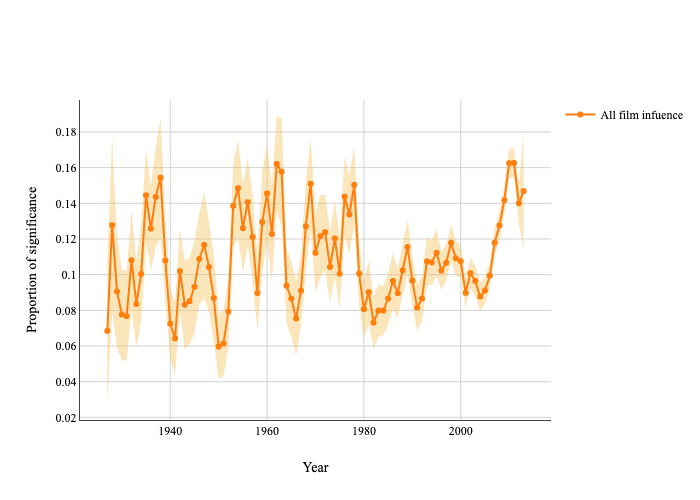

In [18]:
fig = go.Figure([
    go.Scatter(
        name='Upper Bound',
        x=ci_per_year_df['year'],
        y=ci_per_year_df['ci_upper'],
        mode='lines',
        # line_shape='spline',
        marker=dict(color="rgb(244,189,85)"),
        line=dict(width=0),
        showlegend=False
    ),
    go.Scatter(
        name='Lower Bound',
        x=ci_per_year_df['year'],
        y=ci_per_year_df['ci_lower'],
        marker=dict(color="rgb(244,189,85)"),
        line=dict(width=0, color="rgb(244,189,85)"),
        # line_shape='spline',
        mode='lines',
        fillcolor='rgba(244,189,85, 0.4)',
        fill='tonexty',
        showlegend=False
    ),
    go.Scatter(
        name='All film infuence',
        x=ci_per_year_df['year'],
        y=ci_per_year_df['mean'],
        mode='lines + markers',
        marker=dict(color="#FF7F0E"),
        line=dict(color="#FF7F0E"),
        # line_shape='spline'
    )
])
fig.update_layout(
    # title='Average general influence of films per month',
    hovermode="x",
    xaxis=dict(title='Year', linewidth=1),
    yaxis=dict(title='Proportion of significance', linewidth=1),
)

fig.update_yaxes(title_standoff=10)

fig.show(renderer="png")

# Export to html
fig.write_html('q1_proportion_total.html', include_plotlyjs="cdn", config={'displayModeBar': False})

In [19]:
# total_name_by_movie.reset_index(inplace=True)
total_name_by_movie = total_name_by_movie[(total_name_by_movie['year'] >= 1927) & (total_name_by_movie['year'] <= 2013)].copy(deep=True)

season_mapping = {
    1: 'Winter', 2: 'Winter', 3: 'Spring',
    4: 'Spring', 5: 'Spring', 6: 'Summer',
    7: 'Summer', 8: 'Summer', 9: 'Fall',
    10: 'Fall', 11: 'Fall', 12: 'Winter'
}

# Create a new 'season' column based on the mapping
total_name_by_movie['season'] = total_name_by_movie['month'].map(season_mapping)

# Drop NaN values in the season column
total_name_by_movie.dropna(subset=['season'], inplace=True)

display(total_name_by_movie.sample(2))
print(f"Length of the 'total_name_by_movie' dataframe: {len(total_name_by_movie)}")

,char_words,order,gender,t_stat,p_value,slope_change,mov_name,year,month,revenue,numVotes,averageRating,is_significant,season
wiki_ID,,,,,,,,,,,,,,
20828775,Hakeem,NaN,M,-1.962722,0.075463,0.000324,Aloo Chaat,2009,3.0,NaN,965,5.9,0,Spring
31685199,Sally,NaN,F,0.640823,0.534760,-0.000179,Sirens,1999,9.0,NaN,248,5.0,0,Fall


Length of the 'total_name_by_movie' dataframe: 122942


season,year,Fall,Spring,Summer,Winter
77,2004,0.083689,0.084011,0.079153,0.096396
23,1950,0.078125,0.069767,0.039370,0.060150


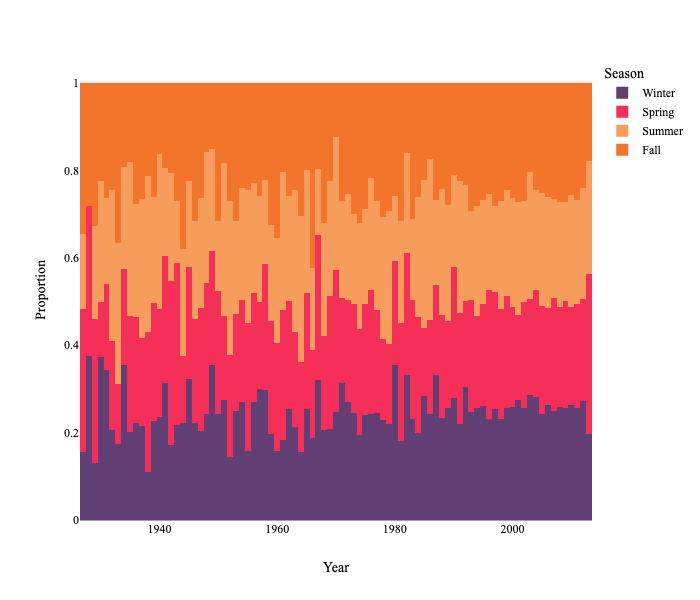

In [20]:
# Group by 'year' and 'season' and calculate the fraction for each season
df_grouped = total_name_by_movie.groupby(['year', 'season'])['is_significant'].mean().reset_index()

# Resetting index to make 'year' and 'category' regular columns
df_reset = df_grouped.reset_index()

# Pivot the table to have 'category' as columns
pivot_table = df_reset.pivot_table(index='year', columns='season', values='is_significant', fill_value=0).reset_index()
display(pivot_table.sample(2))

# Calculate proportions for each category
pivot_table['total'] = pivot_table[['Winter', 'Spring', 'Summer', 'Fall']].sum(axis=1)
pivot_table['proportion_winter'] = pivot_table['Winter'] / pivot_table['total']
pivot_table['proportion_spring'] = pivot_table['Spring'] / pivot_table['total']
pivot_table['proportion_summer'] = pivot_table['Summer'] / pivot_table['total']
pivot_table['proportion_fall'] = pivot_table['Fall'] / pivot_table['total']

# Melt the pivot_table for better plotting
melted_df = pivot_table.melt(id_vars='year', value_vars=['proportion_winter', 'proportion_spring', 'proportion_summer', 'proportion_fall'],
                              var_name='season', value_name='proportion')

colors = ['#613F75', '#F52F57', '#F79D5C', '#F3752B']

# Plotting with Plotly
fig = px.bar(melted_df, x='year', y='proportion', color='season',
             labels={'proportion': 'Proportion', 'year': 'Year', 'season': 'Season'},
             color_discrete_sequence=colors,
             height=600,
            #  title='Proportion of Significance by Season Over Years',
             )

# Update the legend labels for each trace
fig.data[0].name = 'Winter'
fig.data[1].name = 'Spring'
fig.data[2].name = 'Summer'
fig.data[3].name = 'Fall'

fig.update_yaxes(title_standoff=10)
fig.update_layout(bargap=0)

# Show the plot
fig.show(renderer="png")

# Export to html
fig.write_html('q1_proportion_per_season.html', include_plotlyjs="cdn", config={'displayModeBar': False})

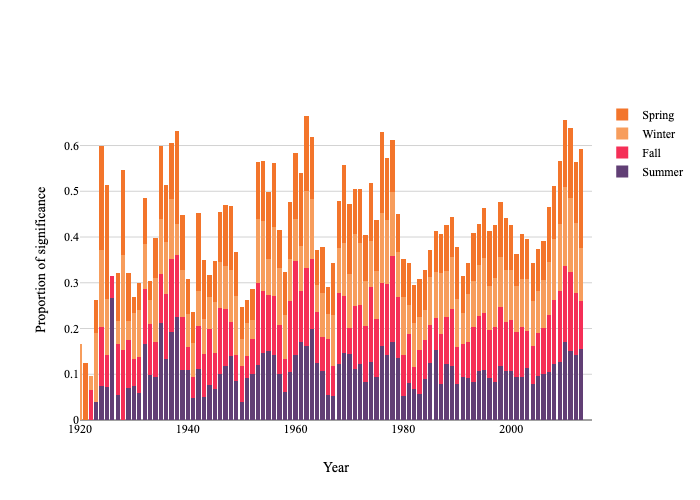

In [21]:
# Define the main line plot for each season
seasons = ['Summer', 'Fall', 'Winter', 'Spring']
colors = ['#613F75', '#F52F57', '#F79D5C', '#F3752B']
data = [summer_movies_df_sorted, fall_movies_df_sorted, winter_movies_df_sorted, spring_movies_df_sorted]

# Bar chart plot
fig = go.Figure()
for i, season in enumerate(seasons):
    fig.add_trace(go.Bar(
        x=data[i]['year'],
        y=data[i]['prop_influenced'],
        name=seasons[i],
        marker_color=colors[i],
        offsetgroup=1
    ))

# Mise en forme du tracé
fig.update_layout(
    # title = "Evolution of number of influenced names per season of movie release",
    xaxis=dict(title='Year'),
    yaxis=dict(title='Proportion of significance'),
    barmode='stack'  # 'stack' empile les barres pour chaque order  
      
)
fig.update_xaxes(range=[1920, 2015])
fig.update_yaxes(title_standoff=10)

fig.show(renderer="png")

# Export to html
fig.write_html('q1_number_signi_season_timeline.html', include_plotlyjs="cdn", config={'displayModeBar': False})

### Average monthly influence magnitude : timeline
After looking at the yearly variation in proportion of significantly influenced names across season/month, it is time to try to quantify the quantitative influenced differentiation between months. First, we study the mean magnitude slope change for each month (January - Decembre) on the average of all significantly influenced names.

In [22]:
# compute the average and standard error of the slope change for each month
influence_per_month_df = name_by_movie_aggregate_df[name_by_movie_aggregate_df['p_value']<alpha].groupby('month').apply(lambda x: pd.Series ({
    'avg_slope_change_significant_per_month': x['slope_change'].mean(),
    'se_slope_change_significant_per_month': x['slope_change'].sem(),
    'avg_mag_slope_change_significant_per_month': x['slope_change'].abs().mean(),
    'se_mag_slope_change_significant_per_month': x['slope_change'].abs().sem()
}))

display(influence_per_month_df.sample(2))

,avg_slope_change_significant_per_month,se_slope_change_significant_per_month,avg_mag_slope_change_significant_per_month,se_mag_slope_change_significant_per_month
month,,,,
10.0,0.003292,0.000687,0.014343,0.000574
11.0,0.000701,0.000809,0.014428,0.000677


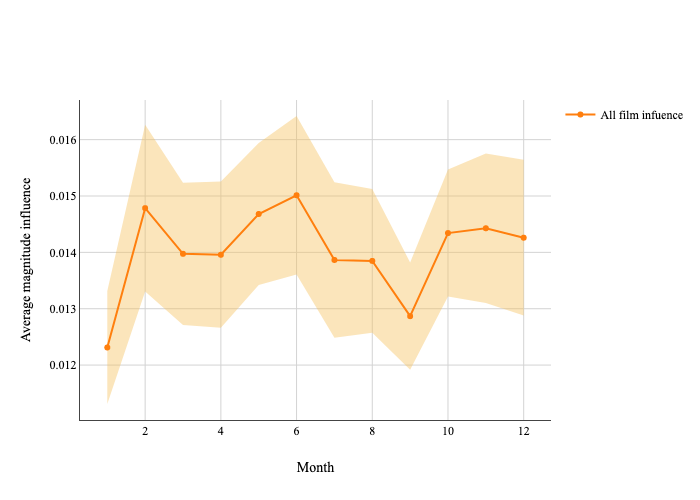

In [23]:
fig = go.Figure([
    go.Scatter(
        name='Upper Bound',
        x=influence_per_month_df.index,
        y=influence_per_month_df['avg_mag_slope_change_significant_per_month']+1.96*influence_per_month_df['se_mag_slope_change_significant_per_month'],
        mode='lines',
        # line_shape='spline',
        marker=dict(color="rgb(244,189,85)"),
        line=dict(width=0),
        showlegend=False
    ),
    go.Scatter(
        name='Lower Bound',
        x=influence_per_month_df.index,
        y=influence_per_month_df['avg_mag_slope_change_significant_per_month']-1.96*influence_per_month_df['se_mag_slope_change_significant_per_month'],
        marker=dict(color="rgb(244,189,85)"),
        line=dict(width=0, color="rgb(244,189,85)"),
        # line_shape='spline',
        mode='lines',
        fillcolor='rgba(244,189,85, 0.4)',
        fill='tonexty',
        showlegend=False
    ),
    go.Scatter(
        name='All film infuence',
        x=influence_per_month_df.index,
        y=influence_per_month_df['avg_mag_slope_change_significant_per_month'],
        mode='lines + markers',
        marker=dict(color="#FF7F0E"),
        line=dict(color="#FF7F0E"),
        # line_shape='spline'
    )
])
fig.update_layout(
    # title='Average general influence of films per month',
    hovermode="x",
    yaxis=dict(title='Average magnitude influence', linewidth=1, title_standoff=10),
    xaxis=dict(title='Month', linewidth=1),
)

fig.update_yaxes(title_standoff=10)

fig.show(renderer="png")

# Export to html
fig.write_html('q1_magnitude_per_month.html', include_plotlyjs="cdn", config={'displayModeBar': False})

Now we look at the variation of magnitude influence per year across season.

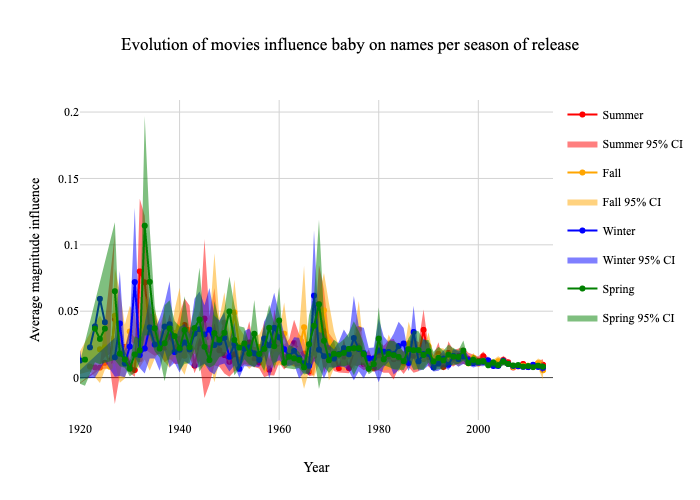

In [24]:
# Create the main figure
fig = go.Figure()

# Define the main line plot for each season
seasons = ['Summer', 'Fall', 'Winter', 'Spring']
colors = ['red', 'orange', 'blue', 'green']
data = [summer_movies_df_sorted, fall_movies_df_sorted, winter_movies_df_sorted, spring_movies_df_sorted]

for i, season in enumerate(seasons):
    main_trace = go.Scatter(
        x=data[i]['year'],  
        y=data[i]['avg'],  
        mode='lines+markers',
        line_shape='linear',
        name=season,
        line=dict(color=colors[i]),
        legendgroup=season,
        #visible=(season == 'Summer')
    )
    
    # Add the main line trace to the figure
    fig.add_trace(main_trace)
    
    # Calculate confidence interval data
    lower_ci = data[i]['avg'] - 1.96*data[i]['se'] 
    upper_ci = data[i]['avg'] + 1.96*data[i]['se']
    
    # Add the trace for confidence interval
    ci_trace = go.Scatter(
        x=data[i]['year'],
        y=upper_ci,
        mode='lines',
        line=dict(color=colors[i], width=0),
        name=f'{season} 95% CI',
        showlegend=False,
        legendgroup=season,
        #visible=(season == 'Summer')
    )
    
    fig.add_trace(ci_trace)
    
    # Add the filled area between the main line and confidence interval
    fig.add_trace(go.Scatter(
        x=data[i]['year'],
        y=lower_ci,
        mode='lines',
        line=dict(color=colors[i], width=0),
        name=f'{season} 95% CI',
        fill='tonexty',
        #fillcolor=f'rgba{((colors[i]), 0.2)}',
        #showlegend=False,
        #legendgroup=season
        #visible=(season == 'Summer')
    ))

# Update the layout
fig.update_layout(
    title='Evolution of movies influence baby on names per season of release',
    xaxis_title='Year',
    yaxis_title='Average magnitude influence',
    #yaxis=dict(type="log"),
    xaxis=dict(range=[1900, 2020])
)

fig.update_xaxes(range=['1920', '2015'])
fig.update_yaxes(title_standoff=10)

# Show the figure
fig.show(renderer="png")


### Influence magnitude for each genre : timeline
A question we can further dive into might be the possible covariates of movie genre on the month of release concerning the influence on baby naming.

Here, we plot the mean magnitude slope change for each month (January - Decembre) for the 5 most represented movie genres in the dataset

In [25]:
# First, aggregate dataframe with p_value with dataframe containing movie genre
movie_genre_aggregate_df = name_by_movie_df.merge(movie_genres_df, how='left', left_on='wiki_ID', right_on='wiki_ID').copy(deep=True)
movie_genre_aggregate_df.reset_index(inplace=True)

In [26]:
# Merge dataframe so that we have the genre of a movie, 
# with its month of release and p_value/slope change
movie_genre_caracteristics_aggregate_df = movie_genre_aggregate_df.merge(movie_df, how='left', left_on='wiki_ID', right_on='wiki_ID')
display(movie_genre_caracteristics_aggregate_df.sample(2))

,wiki_ID,char_words,order,gender,t_stat,p_value,slope_change,genre,mov_name,year,month,revenue,numVotes,averageRating
322198,3623103,Mason,20.0,M,-2.191909,0.050799,0.051963,Cult,Halloween,2007,8.0,80249467.0,128896,6.0
697402,27079761,Lou,NaN,F,-0.610052,0.554221,0.000080,Period piece,Mao's Last Dancer,2009,9.0,NaN,8217,7.3


In [27]:
# Select 5 most represented movie genre in ths dataset
most_representative_genre = movie_genres_df['genre'].value_counts().nlargest(5).index
display(most_representative_genre)


Index(['Drama', 'Comedy', 'Romance Film', 'Thriller', 'Action'], dtype='object', name='genre')

In [28]:
influence_per_month_per_genre_df = movie_genre_caracteristics_aggregate_df[(movie_genre_caracteristics_aggregate_df['p_value']<alpha) & (movie_genre_aggregate_df['genre'].isin(most_representative_genre))].groupby(['genre','month']).apply(lambda x: pd.Series ({
    'avg_slope_change_significant_per_month': x['slope_change'].mean(),
    'se_slope_change_significant_per_month': x['slope_change'].sem(),
    'avg_mag_slope_change_significant_per_month': x['slope_change'].abs().mean(),
    'se_mag_slope_change_significant_per_month': x['slope_change'].abs().sem()
}))

display(influence_per_month_per_genre_df.sample(2))

,,avg_slope_change_significant_per_month,se_slope_change_significant_per_month,avg_mag_slope_change_significant_per_month,se_mag_slope_change_significant_per_month
genre,month,,,,
Thriller,8.0,0.001338,0.001612,0.014618,0.001393
Action,7.0,0.002596,0.001214,0.011586,0.000964


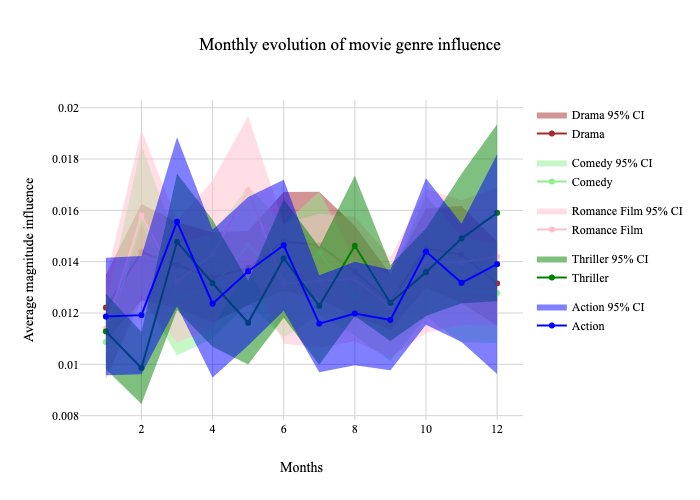

In [29]:
# Create the main figure
fig = go.Figure()

# Define the main line plot for each season
genres = most_representative_genre
colors = ['brown', 'lightgreen', 'pink', 'green', 'blue']
#data = [summer_movies_df_sorted, fall_movies_df_sorted, winter_movies_df_sorted, spring_movies_df_sorted]
influence_per_month_per_genre_df.reset_index(inplace=True)


for i, season in enumerate(genres):
    data = influence_per_month_per_genre_df[influence_per_month_per_genre_df['genre'] == season]
    main_trace = go.Scatter(
        x=data['month'],  # Replace with the actual data
        y=data['avg_mag_slope_change_significant_per_month'],  # Replace with the actual data
        mode='lines+markers',
        line_shape='linear',
        name=season,
        line=dict(color=colors[i]),
        legendgroup=season,
        #visible=(season == 'Summer')
    )
    
    # Add the main line trace to the figure
    fig.add_trace(main_trace)
    
    # Calculate confidence interval data
    lower_ci = data['avg_mag_slope_change_significant_per_month'] - 1.96*data['se_mag_slope_change_significant_per_month']  # Replace with the actual data
    upper_ci = data['avg_mag_slope_change_significant_per_month'] + 1.96*data['se_mag_slope_change_significant_per_month']  # Replace with the actual data
    
    # Add the trace for confidence interval
    ci_trace = go.Scatter(
        x=data['month'],  # Replace with the actual data
        y=upper_ci,
        mode='lines',
        line=dict(color=colors[i], width=0),
        name=f'{season} 95% CI',
        showlegend=False,
        legendgroup=season,
        #visible=(season == 'Summer')
    )
    
    fig.add_trace(ci_trace)
    
    # Add the filled area between the main line and confidence interval
    fig.add_trace(go.Scatter(
        x=data['month'],  # Replace with the actual data
        y=lower_ci,
        mode='lines',
        line=dict(color=colors[i], width=0),
        name=f'{season} 95% CI',
        fill='tonexty',
        # fillcolor=f'rgba{((colors[i]), 0.2)}',  # Adjust the transparency as needed
        #showlegend=False,
        legendgroup=season
        #visible=(season == 'Summer')
    ))

# Update the layout
fig.update_layout(
    title='Monthly evolution of movie genre influence',
    xaxis_title='Months',
    yaxis_title='Average magnitude influence'
)

fig.update_yaxes(title_standoff=10)

# Show the figure
fig.show(renderer="png")


# Question 2 : Does the genre of a movie has an impact on the influence of a movie ?

*Note: The plots concerning this section were directly made in javascript language as their type were quite specific and are thus not present in the notebook. Please refer to the notebook coresponding website page to get visualization of this question. Here, we therefore only generates the appropriated datasets that will be used for the visualization*

By looking at movie genre, one could think about Romance film which are more sentimental and might impact strongly people's mind due to the emotional feelings they pass through the caracter.
In the other hand, comic or action movies are also strongly implemented in the market and have their own set of sentiment, but maybe less on the compassion/feeling side but rather in the act of taking action or making people laugh, without especially giving the opportunity to the viewer to relate to a possible real life or dream love story which we might get through during our life.

In this section, we therefore try to capture whether some movie genre have significantly more influence on baby naming than other, both in term of proportion and magnitude influence.


In [30]:
# Need to drop the duplicates i.e. the instances that have the same wiki_ID for the same genre and same char words if any
movie_genre_aggregate_df.reset_index().drop_duplicates(subset=['genre', 'wiki_ID'], inplace=True)

In [31]:
# Compute the number of film per genre
display(movie_genre_aggregate_df.reset_index().groupby('genre')['wiki_ID'].nunique())

genre
Absurdism                  72
Acid western                7
Action                   4654
Action Comedy             110
Action Thrillers          341
                         ... 
Women in prison films       7
Workplace Comedy           72
World cinema             3350
Wuxia                      34
Zombie Film               102
Name: wiki_ID, Length: 339, dtype: int64

In [32]:
# Compute proportion of significantly impacted names by genre
# Also computation of non significant and nan proportion for sanity check
name_by_genre_prop_df = movie_genre_aggregate_df.groupby('genre').apply(lambda x: pd.Series({
        # Number of film in a given movie genre 
        'nb_films_in_genre': x.reset_index()['wiki_ID'].count(),
        # Number of total different names that appear in a given movie genre
        'nb_names_in_genre': x['char_words'].count(),
        # Number of different names per genre that are significantly impacted by a movie release from that genre
        'nb_names_signi_in_genre': x[x['p_value'] < alpha]['char_words'].count(),
        # Proportion of names significantly impacted by a movie genre divided by total number of films in this movie genre
        'prop_names_signi_in_genre_per_total_film_in_genre': (x[x['p_value'] < alpha]['char_words'].count())/(x.reset_index()['wiki_ID'].count()),
        # Compute proportion of significantly impacted names by genre
        'prop_signif_per_genre': (x['p_value'] < alpha).sum()/len(x['p_value']),
        # Also computation of non significant and nan proportion for sanity check
        'is_na_sum': x['slope_change'].isna().sum(),
        'prop_non_signi': (x['p_value'] > alpha).sum()/len(x['p_value']),
        'prop_nan': (x['p_value'].isna()).sum()/len(x['p_value']),
        # Computation of mean/se of inlfuence/magnitude influence by movie genre
        'avg_slope_change_significant': x[x['p_value'] < alpha]['slope_change'].mean(),
        'se_slope_change_significant': x[x['p_value'] < alpha]['slope_change'].sem(),
        'avg_mag_slope_change_significant': x[x['p_value'] < alpha]['slope_change'].abs().mean(),
        'se_mag_slope_change_significant': x[x['p_value'] < alpha]['slope_change'].abs().sem(),
        'avg_slope_change_global': x['slope_change'].mean()
    }))
display(name_by_genre_prop_df.sample(2))

,nb_films_in_genre,nb_names_in_genre,nb_names_signi_in_genre,prop_names_signi_in_genre_per_total_film_in_genre,prop_signif_per_genre,is_na_sum,prop_non_signi,prop_nan,avg_slope_change_significant,se_slope_change_significant,avg_mag_slope_change_significant,se_mag_slope_change_significant,avg_slope_change_global
genre,,,,,,,,,,,,,
Monster,495.0,495.0,41.0,0.082828,0.082828,0.0,0.682828,0.234343,0.001450,0.003086,0.011383,0.002517,-0.000315
Drama,96748.0,96748.0,9552.0,0.098731,0.098731,0.0,0.777308,0.123961,0.002087,0.000257,0.013672,0.000216,0.000173


In [33]:
# Assess the number of nan values and drop them
display(name_by_genre_prop_df.isna().sum())

# Drop NaN values
name_by_genre_prop_df.dropna(inplace=True)
display(name_by_genre_prop_df)

# Sanity check
name_by_genre_prop_df.isna().sum()

nb_films_in_genre                                     0
nb_names_in_genre                                     0
nb_names_signi_in_genre                               0
prop_names_signi_in_genre_per_total_film_in_genre     0
prop_signif_per_genre                                 0
is_na_sum                                             0
prop_non_signi                                        0
prop_nan                                              0
avg_slope_change_significant                         45
se_slope_change_significant                          64
avg_mag_slope_change_significant                     45
se_mag_slope_change_significant                      64
avg_slope_change_global                               0
dtype: int64

,nb_films_in_genre,nb_names_in_genre,nb_names_signi_in_genre,prop_names_signi_in_genre_per_total_film_in_genre,prop_signif_per_genre,is_na_sum,prop_non_signi,prop_nan,avg_slope_change_significant,se_slope_change_significant,avg_mag_slope_change_significant,se_mag_slope_change_significant,avg_slope_change_global
genre,,,,,,,,,,,,,
Absurdism,721.0,721.0,64.0,0.088766,0.088766,0.0,0.798890,0.112344,0.003319,0.003524,0.014686,0.003029,0.000370
Acid western,30.0,30.0,4.0,0.133333,0.133333,0.0,0.733333,0.133333,0.011989,0.007077,0.011989,0.007077,0.002101
Action,31575.0,31575.0,2995.0,0.094854,0.094854,0.0,0.763325,0.141821,0.001634,0.000441,0.013268,0.000370,0.000169
Action Comedy,984.0,984.0,92.0,0.093496,0.093496,0.0,0.762195,0.144309,-0.000049,0.002079,0.012144,0.001644,0.000061
Action Thrillers,2755.0,2755.0,274.0,0.099456,0.099456,0.0,0.775681,0.124864,-0.000393,0.001593,0.014340,0.001336,0.000197
...,...,...,...,...,...,...,...,...,...,...,...,...,...
Women in prison films,52.0,52.0,7.0,0.134615,0.134615,0.0,0.769231,0.096154,0.017780,0.010870,0.020819,0.009930,0.002551
Workplace Comedy,654.0,654.0,76.0,0.116208,0.116208,0.0,0.804281,0.079511,0.002557,0.001460,0.008550,0.001116,0.000441
World cinema,15344.0,15344.0,945.0,0.061588,0.061588,0.0,0.784541,0.153871,0.000796,0.000640,0.009445,0.000561,-0.000050


nb_films_in_genre                                    0
nb_names_in_genre                                    0
nb_names_signi_in_genre                              0
prop_names_signi_in_genre_per_total_film_in_genre    0
prop_signif_per_genre                                0
is_na_sum                                            0
prop_non_signi                                       0
prop_nan                                             0
avg_slope_change_significant                         0
se_slope_change_significant                          0
avg_mag_slope_change_significant                     0
se_mag_slope_change_significant                      0
avg_slope_change_global                              0
dtype: int64

### Analysis looking at time effects
After looking at the proportion of significantly influenced names or the average of influence in each group, an interesting question would be to look at the yearly evolution of those two quantity and try to assess whether we can identify a clear winner between all those moving genre.

In [34]:
# Need to merge datasets containing "p_value" (name_by_movie_df), "movie_genre" (movie_genres_df), "release_date" (movie_df)
# => aggregate "name_by_movie_aggregate_df" with "movie_genres_df"
movie_genre_aggregate_with_years_df = movie_genre_aggregate_df.merge(movie_df, how='left', left_on='wiki_ID', right_on='wiki_ID')
display(movie_genre_aggregate_with_years_df)

,wiki_ID,char_words,order,gender,t_stat,p_value,slope_change,genre,mov_name,year,month,revenue,numVotes,averageRating
0,3217,Gold,6.0,NaN,NaN,NaN,0.000000,Action,Army of Darkness,1992,10.0,21502796.0,191068,7.4
1,3217,Gold,6.0,NaN,NaN,NaN,0.000000,Comedy,Army of Darkness,1992,10.0,21502796.0,191068,7.4
2,3217,Gold,6.0,NaN,NaN,NaN,0.000000,Time travel,Army of Darkness,1992,10.0,21502796.0,191068,7.4
3,3217,Gold,6.0,NaN,NaN,NaN,0.000000,Black comedy,Army of Darkness,1992,10.0,21502796.0,191068,7.4
4,3217,Gold,6.0,NaN,NaN,NaN,0.000000,Zombie Film,Army of Darkness,1992,10.0,21502796.0,191068,7.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
761818,37478048,Ajay,9.0,M,-0.819213,0.430057,0.000130,Comedy film,Mr. Bechara,1996,NaN,NaN,395,5.4
761819,37501922,Murphy,3.0,F,1.264175,0.232298,-0.000365,Drama,Terminal Bliss,1992,NaN,NaN,245,4.4
761820,37501922,Hunter,1.0,M,-7.083089,0.000020,0.036603,Drama,Terminal Bliss,1992,NaN,NaN,245,4.4
761821,37501922,John,1.0,M,-2.172964,0.052505,0.012557,Drama,Terminal Bliss,1992,NaN,NaN,245,4.4


In [35]:
# Compute proportion of impacted names by genre by year 
# Compute also mean and se of significant influences per year
name_by_genre_per_year_prop_df = movie_genre_aggregate_with_years_df.groupby(['genre','year']).apply(lambda x: pd.Series({
        'prop_signif_per_genre_per_year': (x['p_value'] < alpha).sum()/len(x['p_value']),
        'avg_slope_change_significant': x[x['p_value'] < alpha]['slope_change'].mean(),
        'se_slope_change_significant': x[x['p_value'] < alpha]['slope_change'].sem(),
        'avg_mag_slope_change_significant': x[x['p_value'] < alpha]['slope_change'].abs().mean(),
        'se_slope_change_magnitude_significant': x[x['p_value'] < alpha]['slope_change'].abs().sem(),
        'avg_slope_change_global': x['slope_change'].mean()
    }))
display(name_by_genre_per_year_prop_df.sample(2))

,,prop_signif_per_genre_per_year,avg_slope_change_significant,se_slope_change_significant,avg_mag_slope_change_significant,se_slope_change_magnitude_significant,avg_slope_change_global
genre,year,,,,,,
Action,1948,0.067568,0.014908,0.018028,0.029141,0.012972,-0.000060
Americana,1959,0.333333,0.014511,NaN,0.014511,NaN,0.005255


#### Need to fill the missing year for each genre with 0 for further plotting

In [36]:
# Define a dataframe corespnding to the span of years appearing in the movie dataset
all_years_df = pd.DataFrame({'year': range(movie_df['year'].min(), movie_df['year'].max() + 1)}).reset_index(drop=True)
all_years_df = all_years_df.set_index('year', drop=True)
#display(all_years_df)

# Define a function to fill gaps and add corresponding values
def fill_gaps(group):
    filled_group = pd.merge(all_years_df, group, on='year', how='left').fillna(0)
    return filled_group

# First reset index 
name_by_genre_per_year_prop_df.reset_index(inplace=True)
#display(name_by_genre_per_year_prop_df)

# Then apply function filling gaps
name_by_genre_per_year_prop_filled_df = name_by_genre_per_year_prop_df.groupby('genre').apply(fill_gaps)
display(name_by_genre_per_year_prop_filled_df)

year genre  prop_signif_per_genre_per_year  \
genre                                                         
Absurdism   0    1888     0                             0.0   
            1    1889     0                             0.0   
            2    1890     0                             0.0   
            3    1891     0                             0.0   
            4    1892     0                             0.0   
...               ...   ...                             ...   
Zombie Film 124  2012     0                             0.0   
            125  2013     0                             0.0   
            126  2014     0                             0.0   
            127  2015     0                             0.0   
            128  2016     0                             0.0   

                 avg_slope_change_significant  se_slope_change_significant  \
genre                                                                        
Absurdism   0                             0.0                          0.0   
            1                             0.0                          0.0   
            2                             0.0                          0.0   
            3                             0.0                          0.0   
            4                             0.0                          0.0   
...                                       ...                          ...   
Zombie Film 124                           0.0                          0.0   
            125                           0.0                          0.0   
            126                           0.0                          0.0   
            127                           0.0                          0.0   
            128                           0.0                          0.0   

                 avg_mag_slope_change_significant  \
genre                                               
Absurdism   0                                 0.0   
            1                                 0.0   
            2                                 0.0   
            3                                 0.0   
            4                                 0.0   
...                                           ...   
Zombie Film 124                               0.0   
            125                               0.0   
            126                               0.0   
            127                               0.0   
            128                               0.0   

                 se_slope_change_magnitude_significant  \
genre                                                    
Absurdism   0                                      0.0   
            1                                      0.0   
            2                                      0.0   
            3                                      0.0   
            4                                      0.0   
...                                                ...   
Zombie Film 124                                    0.0   
            125                                    0.0   
            126                                    0.0   
            127                                    0.0   
            128                                    0.0   

                 avg_slope_change_global  
genre                                     
Absurdism   0                        0.0  
            1                        0.0  
            2                        0.0  
            3                        0.0  
            4                        0.0  
...                                  ...  
Zombie Film 124                      0.0  
            125                      0.0  
            126                      0.0  
            127                      0.0  
            128                      0.0  

[43731 rows x 8 columns]

In [37]:
# In order to avoid to overcrowd our visualization, we select to display 
# only the yearly evolution for genre with an high resolution i.e., a 
# minimum number of nonzero entries in the years.

# First drop the column genre in order to also reset the index which was also genre
name_by_genre_per_year_prop_filled_df.drop(columns=['genre'], inplace=True)
name_by_genre_per_year_prop_filled_df.reset_index(inplace=True)
display(name_by_genre_per_year_prop_filled_df.sample(2))


# Count the number of non-zero values for each genre
genre_counts = name_by_genre_per_year_prop_filled_df[name_by_genre_per_year_prop_filled_df['avg_slope_change_significant'] != 0].groupby('genre')['year'].nunique()
display(genre_counts)

# Filter out movie genres with fewer than x (=50) non-zero years
threshold = 50
selected_genres = genre_counts[genre_counts >= threshold].index
display(selected_genres)


# Filter the original DataFrame based on the selected genres
name_by_genre_per_year_prop_filled_filtered_df = name_by_genre_per_year_prop_filled_df[name_by_genre_per_year_prop_filled_df['genre'].isin(selected_genres)]
display(name_by_genre_per_year_prop_filled_filtered_df.sample(2))

# Dropping parasitic appearing columns
name_by_genre_per_year_prop_filled_filtered_df.drop(columns=['level_1'], inplace=True)

,genre,level_1,year,prop_signif_per_genre_per_year,avg_slope_change_significant,se_slope_change_significant,avg_mag_slope_change_significant,se_slope_change_magnitude_significant,avg_slope_change_global
28557,Musical comedy,48,1936,0.0,0.0,0.0,0.0,0.0,0.0
2898,Anthropology,60,1948,0.0,0.0,0.0,0.0,0.0,0.0


genre
Absurdism                25
Acid western              4
Action                   89
Action Comedy            23
Action Thrillers         42
                         ..
Women in prison films     3
Workplace Comedy         22
World cinema             64
Wuxia                     4
Zombie Film              19
Name: year, Length: 294, dtype: int64

Index(['Action', 'Action/Adventure', 'Adventure', 'Animation',
       'Biographical film', 'Biography', 'Biopic [feature]', 'Black-and-white',
       'Bollywood', 'Comedy', 'Comedy film', 'Comedy-drama', 'Coming of age',
       'Costume drama', 'Crime Drama', 'Crime Fiction', 'Crime Thriller',
       'Cult', 'Detective', 'Drama', 'Family Drama', 'Family Film', 'Fantasy',
       'Film adaptation', 'Horror', 'Indie', 'Melodrama', 'Musical', 'Mystery',
       'Parody', 'Period piece', 'Political drama', 'Psychological thriller',
       'Romance Film', 'Romantic comedy', 'Romantic drama', 'Satire',
       'Science Fiction', 'Short Film', 'Sports', 'Spy', 'Suspense',
       'Thriller', 'War film', 'Western', 'World cinema'],
      dtype='object', name='genre')

,genre,level_1,year,prop_signif_per_genre_per_year,avg_slope_change_significant,se_slope_change_significant,avg_mag_slope_change_significant,se_slope_change_magnitude_significant,avg_slope_change_global
12208,Crime Fiction,82,1970,0.034783,-0.037040,0.021965,0.038041,0.021387,-0.003912
17409,Fantasy,123,2011,0.142410,0.005877,0.001082,0.008534,0.000863,0.001061


/var/folders/cs/cqp8w_wx22z97051x7c776jm0000gn/T/ipykernel_63093/125854209.py:26: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [38]:
# Sanity check on the Nan values. If there is still some, drop them.
display(name_by_genre_per_year_prop_filled_filtered_df.isna().sum())

genre                                    0
year                                     0
prop_signif_per_genre_per_year           0
avg_slope_change_significant             0
se_slope_change_significant              0
avg_mag_slope_change_significant         0
se_slope_change_magnitude_significant    0
avg_slope_change_global                  0
dtype: int64

#### Saving the data
Create csv files named `movie_genre_significant` and `movie_genre_per_year_significant` to store the results and used them to display interactive plot directly in the website as Circle Packing.

In [39]:
# Path to saved files i.e., `web_data` since the data saved as csv will be used in the website to generate nice interactive plots
ready_for_web = './data/web_data/'

# Filter previous dataframe on the subset of selected movie genre for consitiency in plotting
name_by_genre_prop_df.reset_index(inplace=True)
name_by_genre_prop_filtered_df = name_by_genre_prop_df[name_by_genre_prop_df['genre'].isin(selected_genres)]
#display(name_by_genre_prop_filtered_df)
# Add the genre as a column of the dataframe and save as csv
name_by_genre_prop_filtered_df.to_csv(os.path.join(ready_for_web, 'movie_genre_significant.csv'), index=False)

# Add the genre as a column of the dataframe and save as csv
name_by_genre_per_year_prop_filled_filtered_df.to_csv(os.path.join(ready_for_web, 'movie_genre_per_year_significant.csv'), index=False)

# Question 3 : Effect of movie's popularity on baby naming

We have p_value and slope_change <br>
**p_value** : represent how much we are certain about whether there is a variation or not <br>
**slope_change** : represent the intensity of the variation <br>
**t_stat** : we don't really care, there is the slope change for that <br>

Problem 1 : older movies have less ratings and there are less old movies than recent ones. Therefore we have to take into account the period. <br>
Solution : we will perform matching on the release year. `Warning`: Don't match characters of the same movie!! –> But this won't be an issue since the treated and control group will be distinghuisd based on the number of votes a given movie has. Thus all the names influenced by a given movie will have the same value for the number of votes thus will be in the same group after matching and will therefore not be matched together.

As a first step we will split the `name_by_movie` dataframe into two dataframes that will contains the most and the least known movie characters respectively, with the `numVotes` variable as the vector caracterising popularity. We will use the median in order to split evenly the dataframe. We will then compare the proportion of characters with significant influence on the related name.

In [40]:
movie_genre_aggregate_with_years_df = movie_genre_aggregate_df.merge(movie_df, how='left', left_on='wiki_ID', right_on='wiki_ID')

# Select initial required dataframe
matching_df = movie_genre_aggregate_with_years_df

# drop the nan values
matching_df.dropna(subset=['order', 'numVotes', 'genre', 'gender', 'order', 'p_value'], inplace=True)

# add a column containing 1 if significant and 0 if not
matching_df['is_significant'] = (matching_df['p_value'] < alpha).astype(int)
display(matching_df.sample(2))

,wiki_ID,char_words,order,gender,t_stat,p_value,slope_change,genre,mov_name,year,month,revenue,numVotes,averageRating,is_significant
267668,2523070,Nani,2.0,F,0.624115,0.545278,-0.000060,Children's Fantasy,Lilo & Stitch 2: Stitch Has a Glitch,2005,8.0,NaN,16787,6.2,0
453609,8760676,Elspeth,7.0,F,-1.157962,0.271403,0.000063,Childhood Drama,My Life So Far,1999,7.0,635620.0,3119,6.5,0


In [41]:
# split the dataframe into two dataframe of equal size using the median of the number of votes
median_numVotes = matching_df['numVotes'].median()
matching_df_50_low = matching_df[matching_df['numVotes'] < median_numVotes]
matching_df_50_high = matching_df[matching_df['numVotes'] >= median_numVotes]

# split again both dataframe into two dataframe of equal size using the median of the number of votes
median_50_low = matching_df_50_low['numVotes'].median()
matching_df_quarter_1 = matching_df_50_low[matching_df_50_low['numVotes'] < median_50_low]
matching_df_quarter_2 = matching_df_50_low[matching_df_50_low['numVotes'] >= median_50_low]
median_50_high = matching_df_50_high['numVotes'].median()
matching_df_quarter_3 = matching_df_50_high[matching_df_50_high['numVotes'] < median_50_high]
matching_df_quarter_4 = matching_df_50_high[matching_df_50_high['numVotes'] >= median_50_high]

In [42]:
# check the length of each dataframe
print(f"matching_df_quarter_1 length : {len(matching_df_quarter_1)}")
print(f"matching_df_quarter_2 length : {len(matching_df_quarter_2)}")
print(f"matching_df_quarter_3 length : {len(matching_df_quarter_3)}")
print(f"matching_df_quarter_4 length : {len(matching_df_quarter_4)}")

# check the means of each dataframe
print(f"matching_df_quarter_1 mean : {matching_df_quarter_1['numVotes'].mean()}")
print(f"matching_df_quarter_2 mean : {matching_df_quarter_2['numVotes'].mean()}")
print(f"matching_df_quarter_3 mean : {matching_df_quarter_3['numVotes'].mean()}")
print(f"matching_df_quarter_4 mean : {matching_df_quarter_4['numVotes'].mean()}")

matching_df_quarter_1 length : 134508
matching_df_quarter_2 length : 134594
matching_df_quarter_3 length : 134509
matching_df_quarter_4 length : 134653
matching_df_quarter_1 mean : 807.0199318999613
matching_df_quarter_2 mean : 6453.283118118193
matching_df_quarter_3 mean : 38266.27035365663
matching_df_quarter_4 mean : 294084.3814025681


In [43]:
# Function to compute proportion of significant values and corresponding standard error for confidence interval
def q3_prop_and_ci(data, value_col):
    proportion = (data[value_col] < alpha).mean()
    se = st.sem((data[value_col] < alpha).astype(int))

    ci_upper = proportion + 1.96*se
    ci_lower = proportion - 1.96*se
    return pd.Series({
        'proportion': proportion,
        'ci_lower': ci_lower,
        'ci_upper': ci_upper
    })

prop_quarter_1 = q1_prop_and_ci(matching_df_quarter_1)
prop_quarter_2 = q1_prop_and_ci(matching_df_quarter_2)
prop_quarter_3 = q1_prop_and_ci(matching_df_quarter_3)
prop_quarter_4 = q1_prop_and_ci(matching_df_quarter_4)

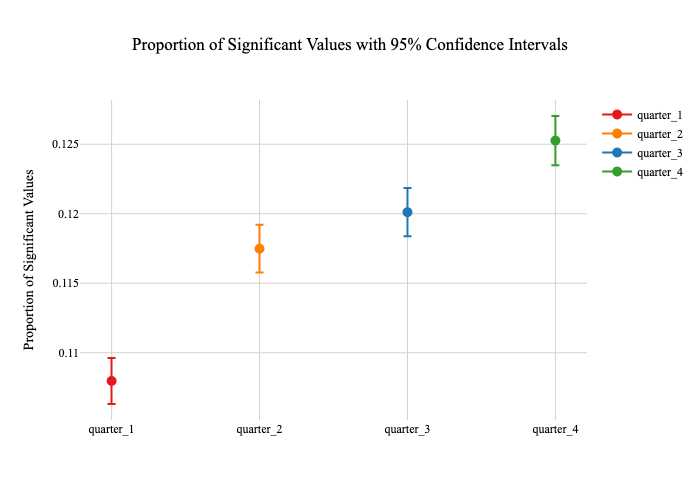

In [44]:
# Create a Plotly figure
fig = go.Figure()

quarters = ['quarter_1', 'quarter_2', 'quarter_3', 'quarter_4']
colors = ['#e31a1c', '#ff7f00', '#1f78b4', '#33a02c']

# Loop through seasons
for quarter, color in zip(quarters, colors):
    prop_data = locals()[f'prop_{quarter.lower()}']  # Access the variable dynamically
    
    # Define y values and error array
    y_values = [prop_data['proportion']]
    error_array = [prop_data['proportion'] - prop_data['ci_lower'], prop_data['ci_upper'] - prop_data['proportion']]
    
    # Add trace to the figure
    fig.add_trace(go.Scatter(
        x=[quarter],
        y=y_values,
        error_y=dict(type='data', array=error_array),
        mode='markers+lines',
        name=quarter,
        marker=dict(color=color, size=10)
    ))

# Update layout for better visualization
fig.update_layout(
    yaxis=dict(title='Proportion of Significant Values'),
    title='Proportion of Significant Values with 95% Confidence Intervals'
)

fig.update_yaxes(title_standoff=10)

# # Customize x ticks
# fig.update_xaxes(
#     tickvals=list(range(len(quarters))),
#     ticktext=['1', '2', '3', '4']
# )

# Show the plot
fig.show(renderer="png")

In [45]:
# Split the matching_df into two dataframe using the median as a threshold
median = matching_df['numVotes'].median()
print(f"The median of the dataframe matching_df is {median}")
matching_df_low = matching_df[matching_df['numVotes'] < median]
matching_df_high = matching_df[matching_df['numVotes'] >= median]

The median of the dataframe matching_df is 14171.0


In [46]:
# compute the mean and confidence interval for both dataframe

def prop_and_ci(data):
    proportion_influenced = (data['p_value']<alpha).mean()
    se = st.sem((data['p_value']<alpha).astype(int))

    ci_upper = proportion_influenced + 1.96*se
    ci_lower = proportion_influenced - 1.96*se
    return pd.Series({
        'proportion_influenced': proportion_influenced,
        'ci_lower': ci_lower,
        'ci_upper': ci_upper
    })

# Compute proportion and confidence interval of proportion of significantly influenced names in control and treatment groups
prop_significant_high = prop_and_ci(matching_df_high)
prop_significant_low = prop_and_ci(matching_df_low)

# Concatenate as columns in order to easily retrieve event of control (column = 0) and treated (column = 1)
# when plotting
prop_significant = pd.DataFrame((prop_significant_low,prop_significant_high), columns=['proportion_influenced', 'ci_lower', 'ci_upper'])
display(prop_significant)

,proportion_influenced,ci_lower,ci_upper
0,0.112730,0.111536,0.113925
1,0.122688,0.121449,0.123928


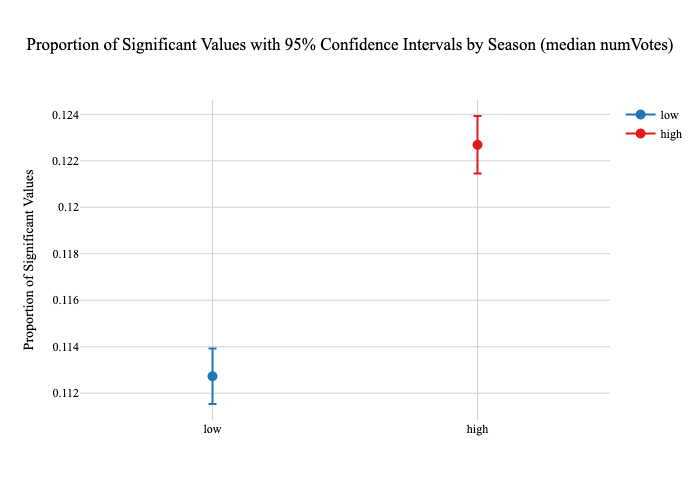

In [47]:
# Create a Plotly figure
fig = go.Figure()

groups = ['low', 'high']
colors = ['#1f78b4', '#e31a1c']

for group, color in zip(groups, colors):
    prop_data = locals()[f'prop_significant_{group.lower()}']
    fig.add_trace(go.Scatter(
        x=[group],
        y=[prop_data['proportion_influenced']],
        error_y=dict(type='data', array=[prop_data['proportion_influenced'] - prop_data['ci_lower'], prop_data['ci_upper'] - prop_data['proportion_influenced']]),
        mode='markers+lines',
        name=group,
        marker=dict(color=color, size=10)
    ))

fig.update_layout(
    yaxis=dict(title='Proportion of Significant Values'),
    title='Proportion of Significant Values with 95% Confidence Intervals by Season (median numVotes)'
)

fig.update_yaxes(title_standoff=10)

# Update layout to adjust the range of the x-axis
fig.update_layout(
    xaxis=dict(range=[-0.5, len(groups) - 0.5]),  # Adjust the range based on your data
)

fig.show(renderer="png")

### Matching on gender, character order, movie genre and year. 
Since capturing the effect of the popularity of a film can be quite challenging looking only at the variable `numVotes`, we now try to isolate its true effect by discarding all potential effect of other observed variables possibly problematic. To do so, we perform exact matching on the gender (as people might relate more to a female in a given situational role in a movie genre rather than a man, or vice versa), character order (by intuition, the headliners in a film are often the ones that would impact the public the most by their large screen time), movie genre (as romance film might possible have wider impact than drama) and year of release.

#### Step 1: establishing dataframe
We first set up the dataframe that contains all the required movie characteristics i.e.,  `p_value`, `slope_change`,`order`, `gender`, `movie_genre`, `year`, `numVotes`. All those properties are contained in a previously defined dataframe named `movie_genre_aggregate_with_years_df`.

In [48]:
# Select initial required dataframe
matching_df = movie_genre_aggregate_with_years_df

# Dropping Nan values on matched caracteristics: movie genre, gender, year, order.
# As well as numVotes since it's the treatment variable and p_value since we will use it to observe significant influence proportion variation
matching_df.dropna(subset=['order', 'numVotes', 'genre', 'gender', 'order', 'p_value'], inplace=True)
display(matching_df)

,wiki_ID,char_words,order,gender,t_stat,p_value,slope_change,genre,mov_name,year,month,revenue,numVotes,averageRating,is_significant
12,3217,Linda,7.0,F,-0.416786,0.684853,0.000673,Action,Army of Darkness,1992,10.0,21502796.0,191068,7.4,0
13,3217,Linda,7.0,F,-0.416786,0.684853,0.000673,Comedy,Army of Darkness,1992,10.0,21502796.0,191068,7.4,0
14,3217,Linda,7.0,F,-0.416786,0.684853,0.000673,Time travel,Army of Darkness,1992,10.0,21502796.0,191068,7.4,0
15,3217,Linda,7.0,F,-0.416786,0.684853,0.000673,Black comedy,Army of Darkness,1992,10.0,21502796.0,191068,7.4,0
16,3217,Linda,7.0,F,-0.416786,0.684853,0.000673,Zombie Film,Army of Darkness,1992,10.0,21502796.0,191068,7.4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
761818,37478048,Ajay,9.0,M,-0.819213,0.430057,0.000130,Comedy film,Mr. Bechara,1996,NaN,NaN,395,5.4,0
761819,37501922,Murphy,3.0,F,1.264175,0.232298,-0.000365,Drama,Terminal Bliss,1992,NaN,NaN,245,4.4,0
761820,37501922,Hunter,1.0,M,-7.083089,0.000020,0.036603,Drama,Terminal Bliss,1992,NaN,NaN,245,4.4,1
761821,37501922,John,1.0,M,-2.172964,0.052505,0.012557,Drama,Terminal Bliss,1992,NaN,NaN,245,4.4,0


In [49]:
# Make a new unique index for each character relevant for the matching
matching_df.set_index(pd.Index(list(range(0,len(matching_df)))), inplace=True)
display(matching_df)

,wiki_ID,char_words,order,gender,t_stat,p_value,slope_change,genre,mov_name,year,month,revenue,numVotes,averageRating,is_significant
0,3217,Linda,7.0,F,-0.416786,0.684853,0.000673,Action,Army of Darkness,1992,10.0,21502796.0,191068,7.4,0
1,3217,Linda,7.0,F,-0.416786,0.684853,0.000673,Comedy,Army of Darkness,1992,10.0,21502796.0,191068,7.4,0
2,3217,Linda,7.0,F,-0.416786,0.684853,0.000673,Time travel,Army of Darkness,1992,10.0,21502796.0,191068,7.4,0
3,3217,Linda,7.0,F,-0.416786,0.684853,0.000673,Black comedy,Army of Darkness,1992,10.0,21502796.0,191068,7.4,0
4,3217,Linda,7.0,F,-0.416786,0.684853,0.000673,Zombie Film,Army of Darkness,1992,10.0,21502796.0,191068,7.4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
538259,37478048,Ajay,9.0,M,-0.819213,0.430057,0.000130,Comedy film,Mr. Bechara,1996,NaN,NaN,395,5.4,0
538260,37501922,Murphy,3.0,F,1.264175,0.232298,-0.000365,Drama,Terminal Bliss,1992,NaN,NaN,245,4.4,0
538261,37501922,Hunter,1.0,M,-7.083089,0.000020,0.036603,Drama,Terminal Bliss,1992,NaN,NaN,245,4.4,1
538262,37501922,John,1.0,M,-2.172964,0.052505,0.012557,Drama,Terminal Bliss,1992,NaN,NaN,245,4.4,0


In [50]:
# In order to perfrom matching, it is required to transform categorical features into
# binary or integer ones. Here the choice to represent movie genre and gender as integer 
# variables (on value of integer for each movie genre or gender) was chosen for simplicity

# Add a new column in name_by_movie_aggregate_genre_df that encode the movie genre
matching_df['genre'] = matching_df['genre'].astype('category')
matching_df['genre_code'] = matching_df['genre'].cat.codes

# Add a new column in name_by_movie_aggregate_genre_df that encode the gender column
# 0 = Women, 1 = Men
matching_df['gender'] = matching_df['gender'].astype('category')
matching_df['gender_code'] = matching_df['gender'].cat.codes

display(matching_df)

,wiki_ID,char_words,order,gender,t_stat,p_value,slope_change,genre,mov_name,year,month,revenue,numVotes,averageRating,is_significant,genre_code,gender_code
0,3217,Linda,7.0,F,-0.416786,0.684853,0.000673,Action,Army of Darkness,1992,10.0,21502796.0,191068,7.4,0,2,0
1,3217,Linda,7.0,F,-0.416786,0.684853,0.000673,Comedy,Army of Darkness,1992,10.0,21502796.0,191068,7.4,0,70,0
2,3217,Linda,7.0,F,-0.416786,0.684853,0.000673,Time travel,Army of Darkness,1992,10.0,21502796.0,191068,7.4,0,313,0
3,3217,Linda,7.0,F,-0.416786,0.684853,0.000673,Black comedy,Army of Darkness,1992,10.0,21502796.0,191068,7.4,0,42,0
4,3217,Linda,7.0,F,-0.416786,0.684853,0.000673,Zombie Film,Army of Darkness,1992,10.0,21502796.0,191068,7.4,0,329,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
538259,37478048,Ajay,9.0,M,-0.819213,0.430057,0.000130,Comedy film,Mr. Bechara,1996,NaN,NaN,395,5.4,0,73,1
538260,37501922,Murphy,3.0,F,1.264175,0.232298,-0.000365,Drama,Terminal Bliss,1992,NaN,NaN,245,4.4,0,108,0
538261,37501922,Hunter,1.0,M,-7.083089,0.000020,0.036603,Drama,Terminal Bliss,1992,NaN,NaN,245,4.4,1,108,1
538262,37501922,John,1.0,M,-2.172964,0.052505,0.012557,Drama,Terminal Bliss,1992,NaN,NaN,245,4.4,0,108,1


#### Step 2 : Create treatment and control group with a separation of the character based on a threshold on the `numVotes` variable
The second step concern the implementation of two dataframes, one for the control where no treatment is given to any of the datapoints in it and the second for the treatment which contains datapoints with the caracterisitc that the control ones don't have. This manoeuvre is set up in order to try to better isolate the effect of a treatment wihtout possibly confounding its effect with the one of other confounders if not balancing and matchiing the two groups.

In our case, the treatment is the **number of votes a film has received**. We chose a threshold based on the distribution of the data of `numVotes`. We first put the threshold as the median of the data, which mean that the control group is the one with a number of votes lower than the one of the median, and the treatment group is the one with a number of votes larger than the one of the median.

Then we were interested to look if modifying this threshold would greatly modify the results so we decided to test with the 25th, 75th and 90th percentile as threshold. All the computation were quite long to run and thus are not all present in this notebook except for the resulting matching pairs in csv files.

In [51]:
import statistics

In [ ]:
# Determination of median value
median = statistics.median(matching_df['numVotes'])

# Filtering to create control (numVotes <= median) and treatment group (numVotes > median)
control_df = matching_df[matching_df['numVotes'] <= median]
treatment_df = matching_df[matching_df['numVotes'] > median]

# Add new column in each dataframe to identify if in treatment or control group
control_df['is_treated'] = 0
treatment_df['is_treated'] = 1

display(control_df.sample(5))
print(f"Length of control population: {len(control_df)}")
display(treatment_df.sample(5))
print(f"Length of treatment population: {len(treatment_df)}")

#### Step 3 : matching
Step 3 is were the magic operates. This is the part were the pairs are establish between the control and the treatment group, were the only "controlled" difference is in the variable of interest i.e., `numVotes`, where the two members of a given pair should absolutely not belong to the same state of the variable of interest. 

In [ ]:
# Columns to use for matching
matching_columns = ['order', 'year', 'genre_code', 'gender_code']

# Initialize a list to store the matched pairs
matched_pairs = []

# Iterate through each row in the control dataframe
for control_index, control_row in control_df.iterrows():
    # Filter the treatment dataframe based on the matching columns
    matching_rows = treatment_df[
        (treatment_df[matching_columns] == control_row[matching_columns]).all(axis=1)
    ]

    # Check if there is a match
    if not matching_rows.empty:
        # Store the index of the matched pair
        treatment_index = matching_rows.index[0]
        matched_pairs.append((control_index, treatment_index))

# Display the matched pairs
print("Matched Pairs:")
print(matched_pairs) # Order of index: control_index, treatment_index

In [ ]:
# Import relevant library to perform maximal matching on pairing
import networkx as nx
# Create graph for further optimal maximal matching
G = nx.Graph()

# Adding edge between pairs
for pair in matched_pairs:
    G.add_edge(pair[0], pair[1])

In [ ]:
# Compute the best matching
matching = nx.maximal_matching(G)

display(list(matching))
print(f"number of matched pairs: {len(matching)}")

v–––––––––––––––––––––––– ## Data Saving ## ––––––––––––––––––––––––v

In [ ]:
# Store the result in a csv file in case of a catastrophic rerun of the cell which would last forever again 
# matching_result_df = pd.DataFrame(matching, columns=['control_data', 'treated_data'])
# matching_result_df.to_csv('matching_result.csv', index=False)

^–––––––––––––––––––––––– ## Data Saving ## ––––––––––––––––––––––––^

v–––––––––––––––––––––––– ## Data Loading ## ––––––––––––––––––––––––v

In [53]:
matching = pd.read_csv('matching_result.csv')

^–––––––––––––––––––––––– ## Data Loading ## ––––––––––––––––––––––––^

In [54]:
# Separate first and second elements of each pair: first element is in control dataframe, second in treatment dataframe

# Cell only valid if full code is run
# index_control = [i[0] for i in list(matching)]
# index_treatment = [i[1] for i in list(matching)]
# print(index_control)
# print(index_treatment)

In [55]:
index_control = matching['control_data'].to_list()
index_treatment = matching['treated_data'].to_list()

In [ ]:
# Sanity check of maximal matching: should return a serie of 'True'
display((matching_df.loc[index_control]['order'].reset_index(drop=True) == matching_df.loc[index_treatment]['order'].reset_index(drop=True)) &
        (matching_df.loc[index_control]['genre_code'].reset_index(drop=True) == matching_df.loc[index_treatment]['genre_code'].reset_index(drop=True)) &
        (matching_df.loc[index_control]['gender_code'].reset_index(drop=True) == matching_df.loc[index_treatment]['gender_code'].reset_index(drop=True)) &
        (matching_df.loc[index_control]['year'].reset_index(drop=True) == matching_df.loc[index_treatment]['year'].reset_index(drop=True)) &
        (matching_df.loc[index_control]['numVotes'].reset_index(drop=True) < median) & (matching_df.loc[index_treatment]['numVotes'].reset_index(drop=True) > median))

In [57]:
# Create new dataframes containing only matched datapoints in treatment and control
matched_control_df = control_df.loc[index_control].copy(deep=True)
matched_treatment_df = treatment_df.loc[index_treatment].copy(deep=True)

# Create concatenated dataframe which contains all elements of the established pairs
matched_aggregate_df = pd.concat([matched_control_df, matched_treatment_df], axis=0)
display(matched_aggregate_df)

,wiki_ID,char_words,order,gender,t_stat,p_value,slope_change,genre,mov_name,year,month,revenue,numVotes,averageRating,is_significant,genre_code,gender_code,is_treated
189199,2354145,Denise,18.0,F,-1.650313,0.127112,0.011452,Comedy,Curse of the Pink Panther,1983,12.0,NaN,6448,4.3,0,70,0,0
150795,1566225,Amy,3.0,F,-2.889696,0.014714,0.013942,Feminist Film,If These Walls Could Talk 2,2000,3.0,NaN,7530,6.9,1,137,0,0
147312,1480747,Sheila,6.0,F,-0.620490,0.547576,0.000807,Teen,House Party 2,1991,10.0,19438638.0,7002,5.3,0,308,0,0
216273,3018980,Rishi,3.0,M,0.198907,0.845965,-0.000048,Fantasy,Thoovanathumbikal,1987,NaN,NaN,4376,8.6,0,131,1,0
269023,4972125,Henrietta,6.0,F,-0.273463,0.789564,0.000026,Biographical film,Love is the Devil: Study for a Portrait of Fra...,1998,9.0,NaN,3938,6.5,0,39,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290,3837,Jim,1.0,M,-2.715964,0.020076,0.006715,Comedy,Blazing Saddles,1974,2.0,119500000.0,147934,7.7,1,70,1,1
148289,1498491,Bart,6.0,M,-0.169531,0.868456,0.000014,Black comedy,Southland Tales,2006,5.0,374743.0,40031,5.3,0,42,1,1
317701,7770667,Ted,13.0,M,-0.721916,0.485410,0.000248,Family Drama,The Ice Storm,1997,9.0,8038061.0,58855,7.3,0,127,1,1
12395,65669,Christiana,7.0,F,0.600835,0.560126,-0.000166,Action,A Knight's Tale,2001,3.0,117487473.0,197245,6.9,0,2,0,1


### Step 4: Variation of proportion of influenced names per year
Once we the matching is done, it is time to look at the results. What better way to do that than with some plots ? We first plot the yearly variation of proportion of significantly influenced names between the control and treatment group to see whether a clear trend emerges

In [58]:
# Create dataframe to show variation of the proportion of significantly names per year
matched_aggregate_df_grouped = matched_aggregate_df.groupby('year').apply(lambda x: pd.Series({
    'prop_significant_control': len(x[(x['p_value'] < alpha) & (x['is_treated'] == 0)])/len(x[x['is_treated'] == 0]),
    'prop_significant_treated': len(x[(x['p_value'] < alpha) & (x['is_treated'] == 1)])/len(x[x['is_treated'] == 1])
}))
display(matched_aggregate_df_grouped)

,prop_significant_control,prop_significant_treated
year,,
1920,0.000000,0.100000
1922,0.000000,0.000000
1926,0.096774,0.000000
1927,0.000000,0.000000
1928,0.222222,0.555556
...,...,...
2009,0.135431,0.177839
2010,0.150703,0.190221
2011,0.168831,0.172827


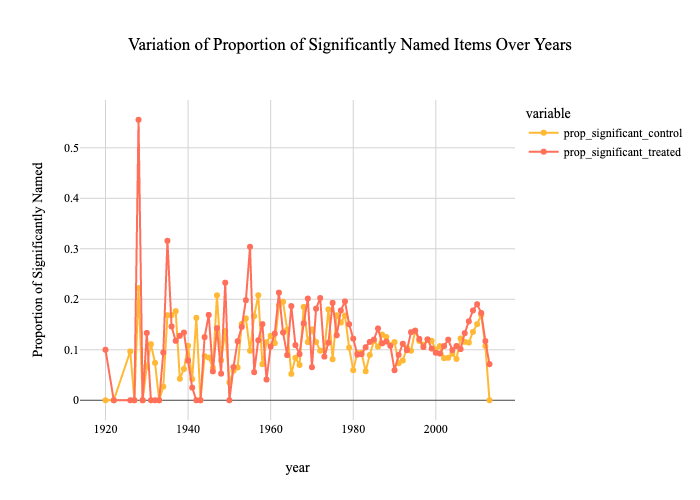

In [59]:
fig = px.line(matched_aggregate_df_grouped.reset_index(), 
              x='year', 
              y=['prop_significant_control', 'prop_significant_treated'],
              labels={'value': 'Proportion of Significantly Named'},
              title='Variation of Proportion of Significantly Named Items Over Years',
              markers=True)
# Show the plot
fig.show(renderer="png")

### Difference in Difference analysis on number of votes
As this graph alone is not really self explanatory, we try to simplify the analysis by perfoming a `Difference in Difference` analysis. We look at the difference in group means between the proportion of significantly influenced names by movies with low popularity i.e., low `numVotes` value i.e., in the control group vs proportion of significantly influenced names by movies with high popularity i.e., high `numVotes` value i.e., in the treatment group. (*Note*: that **high** and **low** popularity is defined by the threshold which is in turn defined by the distribution of the data)

In [60]:
import scipy.stats as st
# Define a function to compute proportion of significantly influenced names and standard error
def prop_and_ci(data):
    proportion_influenced = (data['p_value']<alpha).mean()
    se = st.sem((data['p_value']<alpha).astype(int))

    ci_upper = proportion_influenced + 1.96*se
    ci_lower = proportion_influenced - 1.96*se
    return pd.Series({
        'proportion_influenced': proportion_influenced,
        'ci_lower': ci_lower,
        'ci_upper': ci_upper
    })

In [61]:
# Compute proportion and confidence interval of proportion of significantly influenced names in control and treatmenr groups
prop_significant_treated = prop_and_ci(matched_treatment_df)
prop_significant_control = prop_and_ci(matched_control_df)
display(prop_significant_treated)
display(prop_significant_control)

# Concatenate as columns in order to easily retrieve event of control (column = 0) and treated (column = 1)
# when plotting
prop_significant = pd.concat((prop_significant_control, prop_significant_treated), axis=1)
display(prop_significant)

proportion_influenced    0.124220
ci_lower                 0.120728
ci_upper                 0.127711
dtype: float64

proportion_influenced    0.112116
ci_lower                 0.108776
ci_upper                 0.115455
dtype: float64

,0,1
proportion_influenced,0.112116,0.124220
ci_lower,0.108776,0.120728
ci_upper,0.115455,0.127711


In [62]:
# Save data for dynamic plotting
#prop_significant.to_csv('matching_result_prop.csv', index=False)

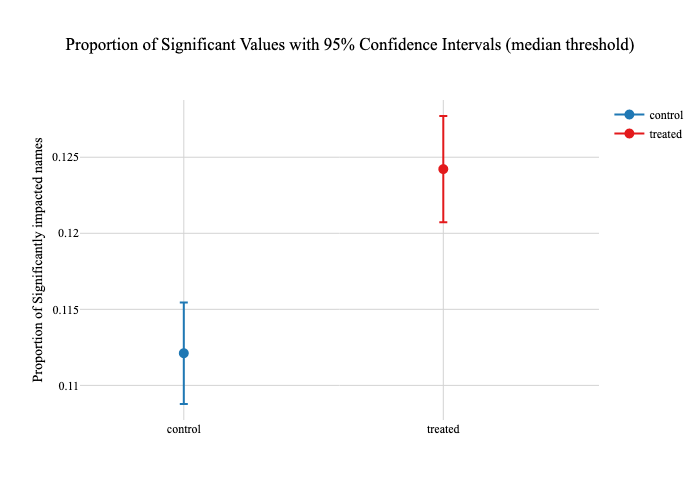

In [63]:
# Create a Plotly figure to display a pointplot
fig = go.Figure()

# Define the two groups and colorblind friendly colors
groups = ['control', 'treated']
colors = ['#1f78b4', '#e31a1c']

for group, color in zip(groups, colors):
    prop_data = locals()[f'prop_significant_{group.lower()}']
    fig.add_trace(go.Scatter(
        x=[group],
        y=[prop_data['proportion_influenced']],
        error_y=dict(type='data', array=[prop_data['proportion_influenced'] - prop_data['ci_lower'], prop_data['ci_upper'] - prop_data['proportion_influenced']]),
        mode='markers+lines',
        name=group,
        marker=dict(color=color, size=10)
    ))

fig.update_layout(
    yaxis=dict(title='Proportion of Significantly impacted names'),
    title='Proportion of Significant Values with 95% Confidence Intervals (median threshold)'
)

fig.update_layout(
    xaxis=dict(range=[-0.4, len(groups) - 0.4]),  # Adjust the range based on your data
)

# Show the plot
fig.show(renderer="png")

From the point plot above, we can clearly see that the confidence interval of the two groups do not overlap, meaning that the difference in group mean is significant at the 5% level.

From that, we don't really get much more results than without the matching besides the fact that when comparing the mean values obtained after matching to the ones obtained without matching, we can observe that the latter are closer and that the confidence interval are wider, which can be explained from the fact that we have less datapoints than without matching, thus we have less precision.

### Further discrimining the unpopular movies
Now that we have observed the effect of separating popular from unpopular movies according to the median of the dataset, we can try to modify the threshold of votes that determines the popularity. We always keep a threshold given by the distribution of the dataset, namely the 25th, 75th and 90th percentiles.

By doing so, we increase the size difference between the control and the treatment group, thus decrease the possible number of pairs, but we allow to better capture the effect popularity related to a movie and its effect on the influence on baby naming.

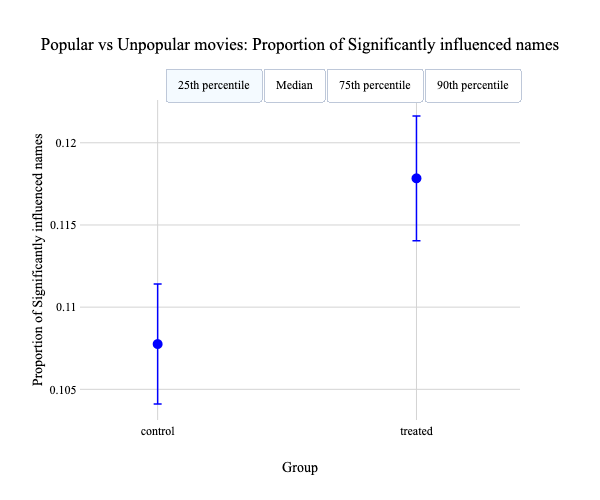

In [64]:
# Plot dynamic point plot for different popularity threshold
# Sample data
data = pd.read_csv('data/web_data/matching_result_prop_significatif.csv')

# Create DataFrame
df = pd.DataFrame(data)
df['group'] = ['control' if i % 2 == 0 else 'treated' for i in range(len(df))]

control_df = df[df['group']=='control'].reset_index(drop=True)
treated_df = df[df['group']=='treated'].reset_index(drop=True)

# Define the different pairs control-treatment
percentile25 = pd.DataFrame((control_df.loc[0], treated_df.loc[0])).reset_index(drop=True)
median= pd.DataFrame((control_df.loc[1], treated_df.loc[1])).reset_index(drop=True)
percentile75 = pd.DataFrame((control_df.loc[2], treated_df.loc[2])).reset_index(drop=True)
percentile90= pd.DataFrame((control_df.loc[3], treated_df.loc[3])).reset_index(drop=True)

# Adjusting traces for vertical orientation
trace_pair_1 = go.Scatter(
    x=percentile25.index,
    y=percentile25['proportion_influenced'],
    mode='markers',
    name='25th percentile',
    marker=dict(color='blue', size=10),
    text=percentile25.index,
    legendgroup='25th percentile',  
    error_y=dict(type='data', array=percentile25['ci_upper'] - percentile25['proportion_influenced'], color='blue', thickness=1.5)
)

trace_pair_2 = go.Scatter(
    x=median.index,
    y=median['proportion_influenced'],
    mode='markers',
    name='Median',
    marker=dict(color='orange', size=10),
    text=median.index,
    legendgroup='Median',
    error_y=dict(type='data', array=median['ci_upper'] - median['proportion_influenced'], color='orange', thickness=1.5)
)

trace_pair_3 = go.Scatter(
    x=percentile75.index,
    y=percentile75['proportion_influenced'],
    mode='markers',
    name='75th percentile',
    marker=dict(color='green', size=10),
    text=percentile75.index,
    legendgroup='75th percentile', 
    error_y=dict(type='data', array=percentile75['ci_upper'] - percentile75['proportion_influenced'], color='green', thickness=1.5)
)

trace_pair_4 = go.Scatter(
    x=percentile90.index,
    y=percentile90['proportion_influenced'],
    mode='markers',
    name='90th percentile',
    marker=dict(color='red', size=10),
    text=percentile90.index,
    legendgroup='90th percentile', 
    error_y=dict(type='data', array=percentile90['ci_upper'] - percentile90['proportion_influenced'], color='red', thickness=1.5)
)

# Creating the figure with all traces
fig = go.Figure(data=[trace_pair_1, trace_pair_2, trace_pair_3, trace_pair_4])

# Set the initial visibility to show control data only
fig.data[0].visible = True
fig.data[1].visible = False
fig.data[2].visible = False
fig.data[3].visible = False

# Updating layout with interactive buttons
fig.update_layout(
    updatemenus=[
        dict(
            type="buttons",
            direction="right",
            active=0, 
            x=1,
            y=1.1,
            buttons=list([
                dict(label="25th percentile",
                     method="update",
                     args=[{"visible": [True, False, False, False]},
                           {"yaxis.range":  [0.1, 0.14],
                            "xaxis.title.text": 'Group'}]),
                dict(label="Median",
                     method="update",
                     args=[{"visible": [False, True, False, False]},
                           {"yaxis.range":  [0.1, 0.14],
                            "xaxis.title.text": 'Group'}]),
                dict(label="75th percentile",
                     method="update",
                     args=[{"visible": [False, False, True, False]},
                           {"yaxis.range":  [0.1, 0.14],
                            "xaxis.title.text": 'Group'}]),
                dict(label="90th percentile",
                     method="update",
                     args=[{"visible": [False, False, False, True]},
                           {"yaxis.range": [0.1, 0.14],
                            "xaxis.title.text": 'Group'}])#,
                            # Possibility to introduce a show all button –> doesn't work well
                # dict(label="Show All",
                #      method="update",
                #      args=[{"visible": [True, True, True, True]},
                #            {"yaxis.range": [0.1, 0.15],
                #             "xaxis.title.text": 'Group'}]),
            ]),
        )
    ],
    xaxis=dict(
        title='Group',
        zeroline=False,
        showgrid=True,
        showline=True,
        linewidth=1,
        linecolor='white',
        tickvals=[0, 1],  # Set tick positions
        ticktext=['control', 'treated']  # Set tick labels
    ),
    yaxis=dict(
        zeroline=False,
        title='Proportion Influenced',
        showgrid=True,
        showline=True,
        linewidth=1,
        linecolor='white',
        dtick=0.005  # Set dtick for finer graduation
    ),
    width=600,  
    #legend=dict(x=1.1, y=1.05) 
)
fig.update_layout(
    yaxis=dict(title='Proportion of Significantly influenced names'),
    title='Popular vs Unpopular movies: Proportion of Significantly influenced names'
)
fig.update_layout(
    xaxis=dict(range=[-0.3, len(groups) - 0.6]),  # Adjust the range based on your data
)
# Show the figure
#fig.show(config={'displayModeBar': False})
fig.write_html('q3_prop_signi_matching.html', include_plotlyjs="cdn", config={'displayModeBar': False})
fig.show(renderer="png")

### Does matching on year is relevant ?
So far we have performed perfect matching on 3 movies caracteristics as well as on the year of release. But is it really that important to match on the year ? Let's explore this question with another matching with same threshold on the popularity but no requirement for year equivalency in pairs between control and treatment group.

The result are displayed in the point-plot below and as we can clearly see

In [65]:
# Creating point plot, by first importing corresponding data
data = pd.read_csv('data/web_data/matching_result_prop_NoYear.csv')
# Convert to dataframe
# df  = pd.DataFrame(data).transpose()
# display(df)
df  = pd.DataFrame(data)
df['group'] = ['control' if i % 2 == 0 else 'treated' for i in range(len(df))]
display(df)

,proportion_influenced,ci_lower,ci_upper,group
0,0.117210,0.109520,0.124899,control
1,0.114532,0.106919,0.122145,treated


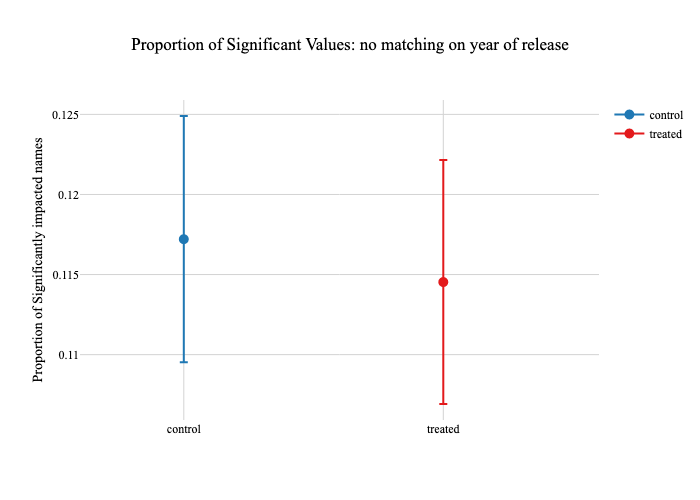

In [66]:
# Create a Plotly figure to display a pointplot
fig = go.Figure()

# Define the two groups and colorblind-friendly colors
groups = ['control', 'treated']
colors = ['#1f78b4', '#e31a1c']

for group, color in zip(groups, colors):
    subset_df = df[df['group'] == group]
    fig.add_trace(go.Scatter(
        x=[group],
        y=subset_df['proportion_influenced'],
        error_y=dict(type='data', array=[subset_df['proportion_influenced'] - subset_df['ci_lower'],
                                         subset_df['ci_upper'] - subset_df['proportion_influenced']]),
        mode='markers+lines',
        name=group,
        marker=dict(color=color, size=10)
    ))

fig.update_layout(
    yaxis=dict(title='Proportion of Significantly impacted names'),
    title='Proportion of Significant Values: no matching on year of release'
)

fig.update_layout(
    xaxis=dict(range=[-0.4, len(groups) - 0.4]),  # Adjust the range based on your data
)

# Show the plot
fig.write_html('q3_prop_signi_no_matching_year.html', include_plotlyjs="cdn", config={'displayModeBar': False})
fig.show(renderer="png")


We get quite an interesting result looking at this pointplot, especially that we cannot say that the difference in proportion of significantly influenced name between the popular and unpopular movies (median threshold) is significant anymore since the confidence interval do overlap !

### What about the qualitative effect obtained with matching ?
The previous analysis were performed on the proportion of significantly influenced names betweeen the control group of unpopular movies and the treated group of popular film to try to assess whether there was a statistically difference between the two after performing exact matching. We are now interested at the qualitative effect that could bring out this perfect matching, namely the difference in magnitude influence between the control and treated group. 

Computation for several popularity threshold were made (25th, median, 75th, 90th percentile) and the first matching was performed considering only the significantly influenced names and matching on same order, movie genre, gender and year of release.

The results of difference in difference analysis is summarized in the dynamic pointplot below:

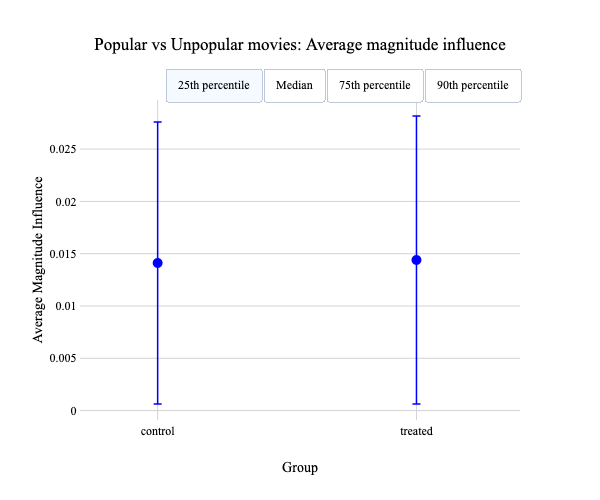

In [67]:
# Plot dynamic point plot for different popularity threshold
# Sample data
data = pd.read_csv('data/web_data/matching_result_influence_significatif.csv')

# Create DataFrame
df = pd.DataFrame(data)
df['group'] = ['control' if i % 2 == 0 else 'treated' for i in range(len(df))]

control_df = df[df['group']=='control'].reset_index(drop=True)
treated_df = df[df['group']=='treated'].reset_index(drop=True)

# Define the different pairs control-treatment
percentile25 = pd.DataFrame((control_df.loc[0], treated_df.loc[0])).reset_index(drop=True)
median= pd.DataFrame((control_df.loc[1], treated_df.loc[1])).reset_index(drop=True)
percentile75 = pd.DataFrame((control_df.loc[2], treated_df.loc[2])).reset_index(drop=True)
percentile90= pd.DataFrame((control_df.loc[3], treated_df.loc[3])).reset_index(drop=True)

# Adjusting traces for vertical orientation
trace_pair_1 = go.Scatter(
    x=percentile25.index,
    y=percentile25['avg_mag_over_all_years'],
    mode='markers',
    name='25th percentile',
    marker=dict(color='blue', size=10),
    text=percentile25.index,
    legendgroup='25th percentile',  
    error_y=dict(type='data', array=1.96*percentile25['se_mag_over_all_years'] - percentile25['avg_mag_over_all_years'], color='blue', thickness=1.5)
)

trace_pair_2 = go.Scatter(
    x=median.index,
    y=median['avg_mag_over_all_years'],
    mode='markers',
    name='Median',
    marker=dict(color='orange', size=10),
    text=median.index,
    legendgroup='Median',
    error_y=dict(type='data', array=1.96*median['se_mag_over_all_years'] - median['avg_mag_over_all_years'], color='orange', thickness=1.5)
)

trace_pair_3 = go.Scatter(
    x=percentile75.index,
    y=percentile75['avg_mag_over_all_years'],
    mode='markers',
    name='75th percentile',
    marker=dict(color='green', size=10),
    text=percentile75.index,
    legendgroup='75th percentile', 
    error_y=dict(type='data', array=1.96*percentile75['se_mag_over_all_years'] - percentile75['avg_mag_over_all_years'], color='green', thickness=1.5)
)

trace_pair_4 = go.Scatter(
    x=percentile90.index,
    y=percentile90['avg_mag_over_all_years'],
    mode='markers',
    name='90th percentile',
    marker=dict(color='red', size=10),
    text=percentile90.index,
    legendgroup='90th percentile', 
    error_y=dict(type='data', array=1.96*percentile90['se_mag_over_all_years'] - percentile90['avg_mag_over_all_years'], color='red', thickness=1.5)
)

# Creating the figure with all traces
fig = go.Figure(data=[trace_pair_1, trace_pair_2, trace_pair_3, trace_pair_4])

# Set the initial visibility to show control data only
fig.data[0].visible = True
fig.data[1].visible = False
fig.data[2].visible = False
fig.data[3].visible = False

# Updating layout with interactive buttons
fig.update_layout(
    updatemenus=[
        dict(
            type="buttons",
            direction="right",
            active=0, 
            x=1,
            y=1.1,
            buttons=list([
                dict(label="25th percentile",
                     method="update",
                     args=[{"visible": [True, False, False, False]},
                           {"yaxis.range":  [0.0, 0.035],
                            "xaxis.title.text": 'Group'}]),
                dict(label="Median",
                     method="update",
                     args=[{"visible": [False, True, False, False]},
                           {"yaxis.range":  [0.0, 0.035],
                            "xaxis.title.text": 'Group'}]),
                dict(label="75th percentile",
                     method="update",
                     args=[{"visible": [False, False, True, False]},
                           {"yaxis.range":  [0.0, 0.035],
                            "xaxis.title.text": 'Group'}]),
                dict(label="90th percentile",
                     method="update",
                     args=[{"visible": [False, False, False, True]},
                           {"yaxis.range": [0.0, 0.035],
                            "xaxis.title.text": 'Group'}])#,
                            # Possibility to introduce a show all button –> doesn't work well
                # dict(label="Show All",
                #      method="update",
                #      args=[{"visible": [True, True, True, True]},
                #            {"yaxis.range": [0.1, 0.15],
                #             "xaxis.title.text": 'Group'}]),
            ]),
        )
    ],
    xaxis=dict(
        title='Group',
        zeroline=False,
        showgrid=True,
        showline=True,
        linewidth=1,
        linecolor='white',
        tickvals=[0, 1],  # Set tick positions
        ticktext=['control', 'treated']  # Set tick labels
    ),
    yaxis=dict(
        title='Average magnitude influence',
        showgrid=True,
        zeroline=False,
        showline=True,
        linewidth=1,
        linecolor='white',
        dtick=0.005  # Set dtick for finer graduation
    ),
    width=600,  
    #legend=dict(x=1.1, y=1.05) 
)
fig.update_layout(
    yaxis=dict(title='Average Magnitude Influence'),
    title='Popular vs Unpopular movies: Average magnitude influence'
)
fig.update_layout(
    xaxis=dict(range=[-0.3, len(groups) - 0.6]),  # Adjust the range based on your data
)
# Show the figure
#fig.show(config={'displayModeBar': False})
fig.write_html('q3_average_magnitude_influence_matching.html', include_plotlyjs="cdn", config={'displayModeBar': False})
fig.show(renderer="png")


From that summary of difference in difference analysis through dynamic pointplot, we can observe that after matching on various popularity threshold, we cannot say that there is a statistically significant change in magnitude influence between popular and unpopular movies.

### Does the results drastically change with further matching on average rating ?

Since we didn't found any statistically significant changes by looking at popularity when matching on 4 features, we can try to further match to possibly have better insight in the effect of movie popularity on the average magnitude influence. To do so, we perform matching on the 4 previous features and add another one, namely the average rating the movie got. By doing so, we try to capture the possible cofounder that might exist between rating and popularity i.e., high rating movies with low number of votes might see their rating questionned compared to a high rating given to a movie with high number of votes. This measure of quality of a movie might possibly affect the outcome of average magnitude influence of movies.

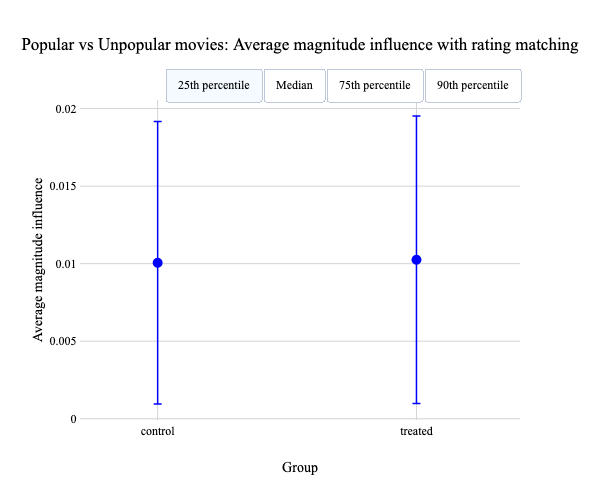

In [68]:
# Plot dynamic point plot for different popularity threshold
# Sample data
data = pd.read_csv('data/web_data/matching_result_influence_rating_significatif.csv')

# Create DataFrame
df = pd.DataFrame(data)
df['group'] = ['control' if i % 2 == 0 else 'treated' for i in range(len(df))]

control_df = df[df['group']=='control'].reset_index(drop=True)
treated_df = df[df['group']=='treated'].reset_index(drop=True)

# Define the different pairs control-treatment
percentile25 = pd.DataFrame((control_df.loc[0], treated_df.loc[0])).reset_index(drop=True)
median= pd.DataFrame((control_df.loc[1], treated_df.loc[1])).reset_index(drop=True)
percentile75 = pd.DataFrame((control_df.loc[2], treated_df.loc[2])).reset_index(drop=True)
percentile90= pd.DataFrame((control_df.loc[3], treated_df.loc[3])).reset_index(drop=True)

# Adjusting traces for vertical orientation
trace_pair_1 = go.Scatter(
    x=percentile25.index,
    y=percentile25['avg_mag_over_all_years'],
    mode='markers',
    name='25th percentile',
    marker=dict(color='blue', size=10),
    text=percentile25.index,
    legendgroup='25th percentile',  
    error_y=dict(type='data', array=1.96*percentile25['se_mag_over_all_years'] - percentile25['avg_mag_over_all_years'], color='blue', thickness=1.5)
)

trace_pair_2 = go.Scatter(
    x=median.index,
    y=median['avg_mag_over_all_years'],
    mode='markers',
    name='Median',
    marker=dict(color='orange', size=10),
    text=median.index,
    legendgroup='Median',
    error_y=dict(type='data', array=1.96*median['se_mag_over_all_years'] - median['avg_mag_over_all_years'], color='orange', thickness=1.5)
)

trace_pair_3 = go.Scatter(
    x=percentile75.index,
    y=percentile75['avg_mag_over_all_years'],
    mode='markers',
    name='75th percentile',
    marker=dict(color='green', size=10),
    text=percentile75.index,
    legendgroup='75th percentile', 
    error_y=dict(type='data', array=1.96*percentile75['se_mag_over_all_years'] - percentile75['avg_mag_over_all_years'], color='green', thickness=1.5)
)

trace_pair_4 = go.Scatter(
    x=percentile90.index,
    y=percentile90['avg_mag_over_all_years'],
    mode='markers',
    name='90th percentile',
    marker=dict(color='red', size=10),
    text=percentile90.index,
    legendgroup='90th percentile', 
    error_y=dict(type='data', array=1.96*percentile90['se_mag_over_all_years'] - percentile90['avg_mag_over_all_years'], color='red', thickness=1.5)
)

# Creating the figure with all traces
fig = go.Figure(data=[trace_pair_1, trace_pair_2, trace_pair_3, trace_pair_4])

# Set the initial visibility to show control data only
fig.data[0].visible = True
fig.data[1].visible = False
fig.data[2].visible = False
fig.data[3].visible = False

# Updating layout with interactive buttons
fig.update_layout(
    updatemenus=[
        dict(
            type="buttons",
            direction="right",
            active=0, 
            x=1,
            y=1.1,
            buttons=list([
                dict(label="25th percentile",
                     method="update",
                     args=[{"visible": [True, False, False, False]},
                           {"yaxis.range":  [0.0, 0.035],
                            "xaxis.title.text": 'Group'}]),
                dict(label="Median",
                     method="update",
                     args=[{"visible": [False, True, False, False]},
                           {"yaxis.range":  [0.0, 0.035],
                            "xaxis.title.text": 'Group'}]),
                dict(label="75th percentile",
                     method="update",
                     args=[{"visible": [False, False, True, False]},
                           {"yaxis.range":  [0.0, 0.035],
                            "xaxis.title.text": 'Group'}]),
                dict(label="90th percentile",
                     method="update",
                     args=[{"visible": [False, False, False, True]},
                           {"yaxis.range": [0.0, 0.035],
                            "xaxis.title.text": 'Group'}])#,
                            # Possibility to introduce a show all button –> doesn't work well
                # dict(label="Show All",
                #      method="update",
                #      args=[{"visible": [True, True, True, True]},
                #            {"yaxis.range": [0.1, 0.15],
                #             "xaxis.title.text": 'Group'}]),
            ]),
        )
    ],
    xaxis=dict(
        title='Group',
        zeroline=False,
        showgrid=True,
        showline=True,
        linewidth=1,
        linecolor='white',
        tickvals=[0, 1],  # Set tick positions
        ticktext=['control', 'treated']  # Set tick labels
    ),
    yaxis=dict(
        title='Average magnitude influence',
        showgrid=True,
        zeroline=False,
        showline=True,
        linewidth=1,
        linecolor='white',
        dtick=0.005  # Set dtick for finer graduation
    ),
    width=600,  
    #legend=dict(x=1.1, y=1.05) 
)
fig.update_layout(
    yaxis=dict(title='Average magnitude influence'),
    title='Popular vs Unpopular movies: Average magnitude influence with rating matching'
)
fig.update_layout(
    xaxis=dict(range=[-0.3, len(groups) - 0.6]),  # Adjust the range based on your data
)
# Show the figure
#fig.show(config={'displayModeBar': False})
fig.show(renderer="png")

Once again, impossible to draw statistically significant conclusions from that analysis since the confidence interval are overlapping. Even though we controlled for the main caracteristics of a movie, we were unable to draw insightful conclusions between popular and unpopular movies when looking at the average magnitude influence, compared to the interesting observations made on the proportion of influenced names.

# Question 4 : Character importance in the film
In this section, we try to answer the question whether the importance of the character in the movie plays a role on the influence on baby names. By intuition, we could estimate that the names ot the first role characters will logically inlfuence more baby naming (if it influences it whatsoever) but the proportion of significantly influenced names for each role might not be that obvious.

First, let's plot the number of character played in a year with significant impact with respect to the importance in movie.

In [69]:
# count the number of significant characters per movie
signi_count_per_order = name_by_movie_df[name_by_movie_df['p_value'] < alpha].reset_index().groupby(['order'])['wiki_ID'].count().copy(deep=True)

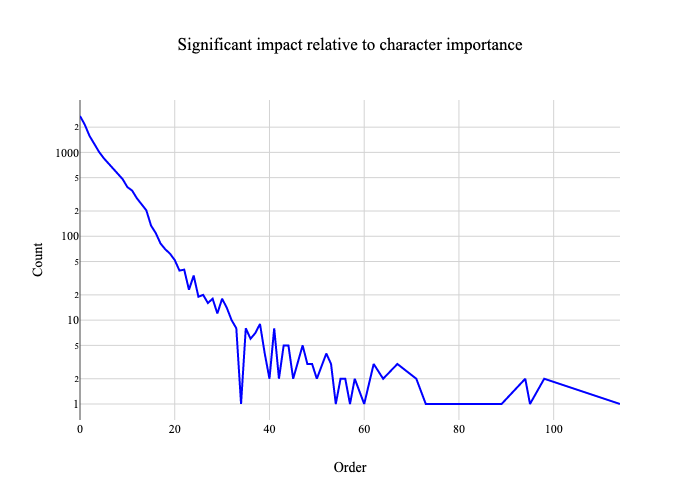

In [70]:
# Create a line plot using Plotly
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=signi_count_per_order.index,
    y=signi_count_per_order.values,
    mode='lines',
    name='Significant Impact',
    line=dict(color='blue')  # You can customize the line color
))

# Add labels and title
fig.update_layout(
    title='Significant impact relative to character importance',
    xaxis=dict(title='Order'),
    yaxis=dict(title='Count', type='log')
)

# Show the plot
fig.show(renderer="png")

With this first inspection, we can see that the greater the importance of characters in the film (i.e. small order), the greater the number of characters having a significant impact on the names given to newborns. 
This result is in line with what we might intuitively expect, that characters make more of an impression on the viewer than characters who appear only infrequently in the film.

We will consider only the first 15 order of importance in the following analysis.

In [71]:
# remove the rows with order higher than 15
name_by_movie_15_df = name_by_movie_df[name_by_movie_df['order'] <= 15].copy(deep=True)

Let's see the proportion of significant character to avoid being biased by the number of movies in each categories.

In [72]:
# compute the percentage of significant characters per order
signi_count_per_order = name_by_movie_15_df[name_by_movie_15_df['p_value'] <= alpha].reset_index().groupby(['order'])['wiki_ID'].count().copy(deep=True)
count_per_order = name_by_movie_15_df.reset_index().groupby(['order'])['wiki_ID'].count().copy(deep=True)
percentage_per_order = (signi_count_per_order / count_per_order)*100
percentage_per_order = percentage_per_order.fillna(0)

# keep only the 15 first orders
percentage_per_order = percentage_per_order[:15]

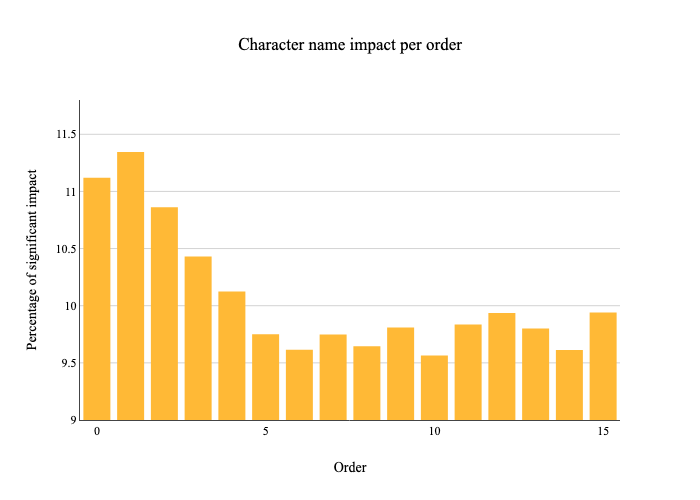

In [73]:
# Plotting with Plotly
fig = px.bar(x=percentage_per_order.index, y=percentage_per_order.values,
             labels={'x': 'Order', 'y': 'Percentage of significant impact'},
             title='Character name impact per order',
             category_orders={'x': percentage_per_order.index})

# Set Y-axis range to highlight small differences
fig.update_layout(yaxis=dict(range=[9, 11.8], linewidth=1),
xaxis=dict(title='Order', linewidth=1))

fig.update_yaxes(title_standoff=10)

# Show the plot
fig.show(renderer="png")

Looking at the percentage of characters with a significant impact within each character order allows us to identify which role type has the greatest number of character names influencing the names of newborns.

Intesting, but let's see the proportion confidence intervals

In [74]:
# add a column in name_by_movie_15_df that contains a one if the variation is significant and zero otherwise
name_by_movie_15_df['is_significant'] = np.where(name_by_movie_15_df['p_value'] <= 0.05, 1, 0)

display(name_by_movie_15_df.sample(2))

,char_words,order,gender,t_stat,p_value,slope_change,is_significant
wiki_ID,,,,,,,
474527,Robin,7.0,F,-2.810065,0.016967,0.001471,1
528256,Bud,11.0,M,-0.265619,0.795445,0.000022,0


In [75]:
def significant_proportion_and_ci(data):

    p = data['is_significant'].mean()
    se = np.sqrt(p * (1 - p) / len(data))

    # Compute confidence interval of 95%, using the mean and standard error
    ci_lower = p - 1.96 * se
    ci_upper = p + 1.96 * se

    # ************************ Alternative way to compute the standard error bis ************************
    # se = st.sem(data['is_significant'])
    # ci_lower = p - 1.96 * se
    # ci_upper = p + 1.96 * se
    # ************************ Alternative way to compute the standard error bis ************************

    # ************************ Alternative way to compute the standard error bis ************************
    # nb_significant = data['is_significant'].sum()
    # total = len(data)
    # (ci_lower, ci_upper) = sm.stats.proportion_confint(nb_significant, total, alpha=0.05)
    # ************************ Alternative way to compute the standard error bis ************************

    # Useful because we will put this in the dataframe
    return pd.Series({
        'mean': p*100,
        'ci_lower': ci_lower*100,
        'ci_upper': ci_upper*100
    })

ci_df = name_by_movie_15_df.groupby(['order']).apply(significant_proportion_and_ci).reset_index()

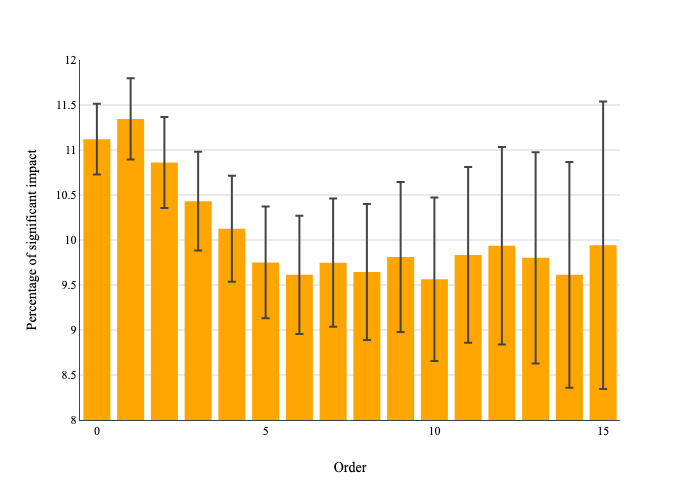

In [76]:
# Plotting with Plotly
fig = px.bar(ci_df, x='order', y='mean',
             labels={'x': 'Order', 'y': 'Percentage of significant impact'},
            #  title='Character name impact per order',
             error_y=ci_df['ci_upper'] - ci_df['mean'],)

# Set Y-axis range to highlight small differences
fig.update_layout(yaxis=dict(title='Percentage of significant impact',  range=[8, 12], linewidth=1),
                  xaxis=dict(title='Order', linewidth=1))

fig.update_traces(marker_color='orange')

fig.update_yaxes(title_standoff=10)

# Show the plot
fig.show(renderer="png")

# Export to html
fig.write_html('q4_signi_percent_per_order.html', include_plotlyjs="cdn", config={'displayModeBar': False})

The intervals are far too large to deduce anything

## Study positive and negative variation

Among the character who played in a year with significant variation on the baby names, let's see the positive and negative variation's mean to compare.

In [77]:
name_by_movie_significant = name_by_movie_15_df[name_by_movie_15_df['is_significant'] == 1].copy(deep=True)

In [78]:
# Create a new column for positive and negative scores
name_by_movie_significant['slope_change_sign'] = name_by_movie_significant['slope_change'].apply(lambda x: 'negative' if x < 0 else 'positive')

# Group by 'order' and 'slope_change_sign', then calculate the mean
grouped_df = name_by_movie_significant.groupby(['order', 'slope_change_sign'])['slope_change'].mean().reset_index()

# Pivot the table for better plotting
pivot_df = grouped_df.pivot(index='order', columns='slope_change_sign', values='slope_change').reset_index()

# Group by 'order' and 'score_type', then calculate the se
se_df = name_by_movie_significant.groupby(['order', 'slope_change_sign'])['slope_change'].sem().reset_index()

# Add the se to the pivot table
pivot_df['neg_se'] = se_df[se_df['slope_change_sign'] == 'negative']['slope_change'].values
pivot_df['pos_se'] = se_df[se_df['slope_change_sign'] == 'positive']['slope_change'].values
display(pivot_df.sample(2))

slope_change_sign,order,negative,positive,neg_se,pos_se
11,11.0,-0.030858,0.008515,0.005433,0.000589
4,4.0,-0.025113,0.009871,0.002171,0.000488


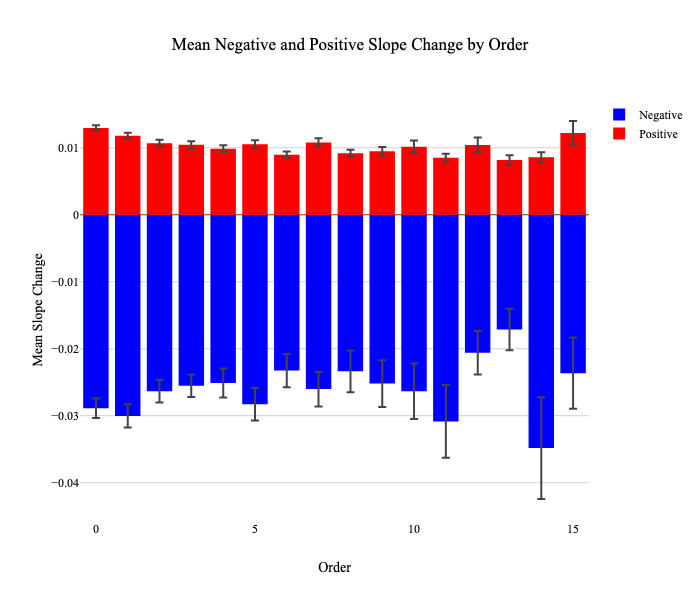

In [79]:
# Plotting with Plotly
fig = px.bar(pivot_df, x='order', y='negative',
             labels={'negative': 'Mean Slope Change', 'order': 'Order'},
             title='Mean Negative and Positive Slope Change by Order',
             height=600,
             error_y='neg_se')

# Update existing traces to show the legend for the color blue
fig.update_traces(marker=dict(color='blue'), selector=dict(type='bar'), showlegend=True, name='Negative')

# Add positive bars with their error values
fig.add_bar(x=pivot_df['order'], y=pivot_df['positive'], 
            error_y=dict(type='data', array=pivot_df['pos_se']),
            name='Positive',
            marker_color='red')

# Show the plot
fig.show(renderer="png")

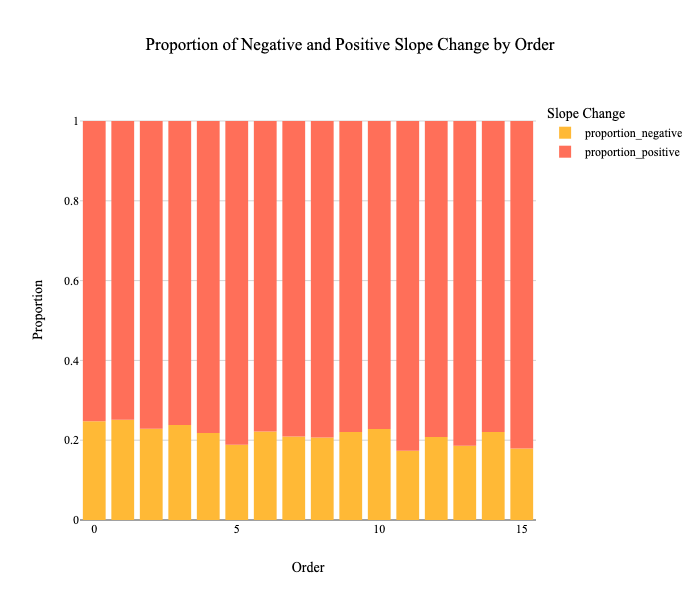

In [80]:
df = name_by_movie_significant.groupby(['order','slope_change_sign']).sum() 
df['is_significant']

# Resetting index to make 'order' a regular column
df_reset = df.reset_index()

# Pivot the table to have 'slope_change_sign' as columns
pivot_table = df_reset.pivot_table(index='order', columns='slope_change_sign', values='is_significant', fill_value=0).reset_index()

# Calculate proportions for negative and positive
pivot_table['total'] = pivot_table['negative'] + pivot_table['positive']
pivot_table['proportion_negative'] = pivot_table['negative'] / pivot_table['total']
pivot_table['proportion_positive'] = pivot_table['positive'] / pivot_table['total']


import plotly.express as px

# Assuming pivot_table is your DataFrame
# Melt the pivot_table for better plotting
melted_df = pivot_table.melt(id_vars='order', value_vars=['proportion_negative', 'proportion_positive'],
                              var_name='slope_change_sign', value_name='proportion')

# Plotting with Plotly
fig = px.bar(melted_df, x='order', y='proportion', color='slope_change_sign',
             labels={'proportion': 'Proportion', 'order': 'Order', 'slope_change_sign': 'Slope Change'},
             title='Proportion of Negative and Positive Slope Change by Order',
             height=600)

# Show the plot
fig.show(renderer="png")

We note that the average slope change per order for negative impacts has a greater magnitude than for positive impacts. However, the proportion of negatively impacting feature names represents less than a quarter of all significant slope change.
For positive slope changes, we note that for the first 5 orders, the influence tends to diminish the less important the character's role. 
This could be intuitively explained by the fact that the less important a character is, the less he or she will have an impact on the audience.

## Magnitude of the variation

We can express the magnitude of the variation by computing the difference of slop before and after the movie release. These differences are already available in the `name_by_movie` dataframe on the column `slope_change`. Let's plot the mean slope change for each order.

In [81]:
alpha = 0.05 # Significance level

name_by_movie_magnitude = name_by_movie_df.copy(deep=True)

# Keep only the significant characters
name_by_movie_magnitude = name_by_movie_magnitude[name_by_movie_magnitude['p_value'] <= alpha]

# Keep only the first 30 orders
name_by_movie_magnitude = name_by_movie_magnitude[name_by_movie_magnitude['order'] <= 20]

# Compute the absolute mean slope change
name_by_movie_magnitude['abs_slope_change'] = name_by_movie_magnitude['slope_change'].abs()
abs_mean_slope_change = name_by_movie_magnitude.groupby("order")['abs_slope_change'].mean()

# Compute the standard error of absolute slope change
abs_slope_change_se = name_by_movie_magnitude.groupby("order")['abs_slope_change'].sem()

# Create a dataframe with the mean and standard error
slope_change_mean_se_df = pd.DataFrame({'abs_mean_slope_change': abs_mean_slope_change, 'abs_slope_change_se': abs_slope_change_se})
display(slope_change_mean_se_df.sample(2))

,abs_mean_slope_change,abs_slope_change_se
order,,
15.0,0.014267,0.001773
7.0,0.013977,0.000771


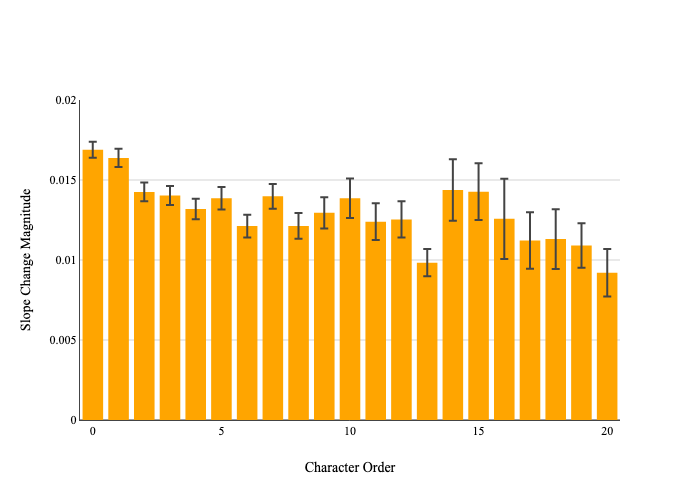

In [82]:
# Création du bar chart interactif avec sous-graphiques
fig = go.Figure()

# Tracé pour avg magnitude slope change avec erreur
fig.add_trace(go.Bar(
    x=slope_change_mean_se_df.index,
    y=slope_change_mean_se_df['abs_mean_slope_change'],
    name='Avg Magnitude Slope Change',
    marker_color='orange',
    error_y=dict(
        type='data',
        array=slope_change_mean_se_df['abs_slope_change_se'],
        visible=True
    )
))

# Set the y-axis range
y_range = [0, 0.02]

# Mise en forme du tracé
fig.update_layout(
    xaxis=dict(title='Character Order', linewidth=1),
    yaxis=dict(title='Slope Change Magnitude', linewidth=1, range=y_range),
    barmode='stack'
)

fig.update_yaxes(title_standoff=10)

fig.show(renderer="png")

# Export to html
fig.write_html('q4_total_slop_change_per_order.html', include_plotlyjs="cdn", config={'displayModeBar': False})

The magnitude of the slope change tends to decrease for the first 5 orders. This reflects the trend of positive slope changes, which are proportionately in the majority for each order.

## Subquestion : Does the order of a name influence differently according to gender ?

In [83]:
name_by_order_by_gender_prop_df = name_by_movie_df.groupby(['order','gender']).apply(lambda x: pd.Series({
        'prop_signif_per_order_per_genre': (x['p_value'] < alpha).sum()/len(x['p_value']),
        'avg_slope_change_significant': x[x['p_value'] < alpha]['slope_change'].mean(),
        'avg_slope_change_global': x['slope_change'].mean(),
        'avg_magnitude_slope_change_significant': x[x['p_value'] < alpha]['slope_change'].abs().mean(),
        'avg_magnitude_slope_change_global': x['slope_change'].abs().mean(),
        'total_number_signif_per_order_per_genre': (x['p_value'] < alpha).sum(),
        'se_slope_change_magnitude_significant': x[x['p_value'] < alpha]['slope_change'].abs().sem()
    }))
display(name_by_order_by_gender_prop_df.sample(2))

,,prop_signif_per_order_per_genre,avg_slope_change_significant,avg_slope_change_global,avg_magnitude_slope_change_significant,avg_magnitude_slope_change_global,total_number_signif_per_order_per_genre,se_slope_change_magnitude_significant
order,gender,,,,,,,
47.0,F,0.111111,0.007988,0.001436,0.007988,0.002035,1.0,NaN
7.0,F,0.112494,0.003784,0.000371,0.015808,0.003124,253.0,0.001432


In [84]:
# Keep only the first 15 orders
name_by_order_by_gender_prop_df.reset_index(inplace=True)
name_by_order_by_gender_prop_df = name_by_order_by_gender_prop_df[name_by_order_by_gender_prop_df['order'] <= 15].copy(deep=True)
name_by_order_by_gender_prop_df.set_index(['order', 'gender'], inplace=True)
display(name_by_order_by_gender_prop_df.sample(2))

,,prop_signif_per_order_per_genre,avg_slope_change_significant,avg_slope_change_global,avg_magnitude_slope_change_significant,avg_magnitude_slope_change_global,total_number_signif_per_order_per_genre,se_slope_change_magnitude_significant
order,gender,,,,,,,
8.0,M,0.085124,0.004316,0.000421,0.011152,0.002119,313.0,0.000888
1.0,F,0.122682,0.000456,-0.000253,0.016857,0.003878,1151.0,0.000859


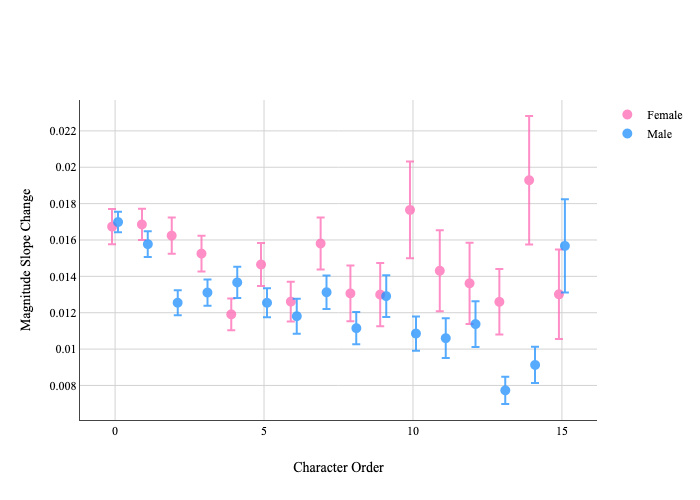

In [85]:
order_values = name_by_order_by_gender_prop_df.index.get_level_values('order').unique()

df_reset = name_by_order_by_gender_prop_df.reset_index()

df_reset['gender'] = df_reset['gender'].replace({'M': 'Male', 'F': 'Female'})

# Separate Male and female for the plot
genders_to_plot = ['Female', 'Male']
colors_1 = ['#FF69B4', '#1E90FF']

# Set the scatter marker size and separation
marker_size = 10  # Adjust as needed
marker_separation = 0.2  # Adjust as needed

# Create traces for each gender
traces = []
for i, gender in enumerate(genders_to_plot):
    # Extract data for the current gender
    gender_data = df_reset[df_reset['gender'] == gender]
    
    # Calculate the offset for side-by-side placement
    offset = (i - 0.5) * marker_separation
    # offset = 0
    
    # Create a scatter trace with error bars
    trace = go.Scatter(
        name=gender,
        x=order_values + offset,
        y=gender_data['avg_magnitude_slope_change_significant'],
        mode='markers',
        marker=dict(size=marker_size, color=colors_1[i]),
        error_y=dict(
            type='data',
            array=gender_data['se_slope_change_magnitude_significant'],
            visible=True
        ),
        hoverinfo='y+text',
        text=gender_data['prop_signif_per_order_per_genre'].apply(lambda x: f'Proportion of significant: {x:.2%}'),
        opacity=0.75,
    )
    
    traces.append(trace)

fig = go.Figure(data=traces)

# Add layout for better visualization
fig.update_layout(
    xaxis=dict(title='Character Order', linewidth=1, zeroline=False),
    yaxis=dict(title='Magnitude Slope Change', linewidth=1)
)

fig.update_yaxes(title_standoff=10)

fig.show(renderer="png")

# Export to html
fig.write_html('q4_slope_change_gender_per_order.html', include_plotlyjs="cdn", config={'displayModeBar': False})

By looking at Magnitude slope change per order and gender we notice that except for the first role and the 4th, it seems that for most roles female character names seem to influence more than male ones.
For the main role, the very similar slope change values for male and female could be explained by the fact that the main character tends to make an impression on the public's mind, regardless of gender.

# Question 5 : Is it possible to differentiate character influence between its gender?

In [86]:
name_by_order_by_gender_prop_df_year = name_by_movie_aggregate_df.groupby(['year','gender']).apply(lambda x: pd.Series({
        'prop_signif_per_order_per_gender': (x['p_value'] < alpha).sum()/len(x['p_value']),
        'avg_slope_change_significant': x[x['p_value'] < alpha]['slope_change'].mean(),
        'avg_slope_change_global': x['slope_change'].mean(),
        'avg_magnitude_slope_change_significant': x[x['p_value'] < alpha]['slope_change'].abs().mean(),
        'avg_magnitude_slope_change_global': x['slope_change'].abs().mean(),
        'total_number_signif_per_order_per_genre': (x['p_value'] < alpha).sum(),
    }))
display(name_by_order_by_gender_prop_df_year.sample(2))

,,prop_signif_per_order_per_gender,avg_slope_change_significant,avg_slope_change_global,avg_magnitude_slope_change_significant,avg_magnitude_slope_change_global,total_number_signif_per_order_per_genre
year,gender,,,,,,
2007,M,0.105363,0.001082,0.000259,0.009599,0.002047,444.0
1989,M,0.096586,-0.002550,-0.000728,0.016794,0.002752,116.0


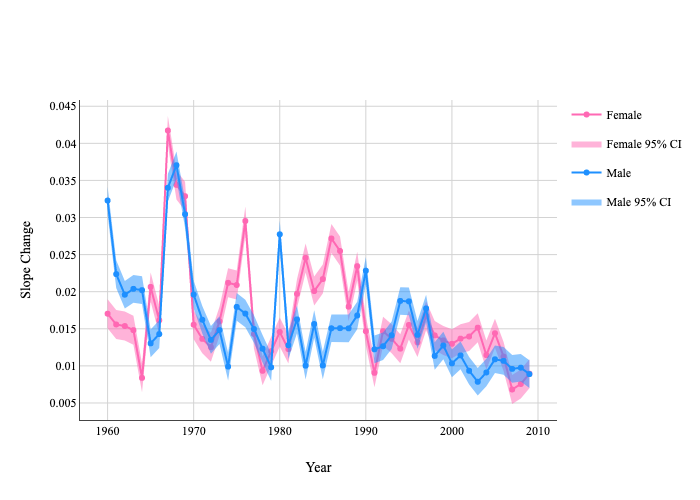

In [87]:
#Plot the average magnitude for significant slope change for Male and Female over years
df_reset = name_by_order_by_gender_prop_df_year.reset_index()

df_reset['gender'] = df_reset['gender'].replace({'M': 'Male', 'F': 'Female'})

# Filter the data for years between 1960 and 2009
df_filtered = df_reset[(df_reset['year'] >= 1960) & (df_reset['year'] <= 2009)]

# Get the unique years from the filtered DataFrame
order_values = df_filtered['year'].unique()

# Select the genders you want to plot
genders_to_plot = ['Female', 'Male']


fig = go.Figure()

# Define the main line plot for each gender using the filtered data
colors= ['#FF69B4', '#1E90FF']

for i, gender in enumerate(genders_to_plot):
    y_values = df_filtered[df_filtered['gender'] == gender]['avg_magnitude_slope_change_significant']
    error_y_values = y_values.sem()

    main_trace = go.Scatter(
        x=order_values,
        y=y_values,
        mode='lines+markers',
        name=gender,
        line=dict(color=colors[i]),
        legendgroup=gender,
    )

    # Add the main line trace to the figure
    fig.add_trace(main_trace)

    # Calculate confidence interval data
    lower_ci = y_values - 1.96 * error_y_values
    upper_ci = y_values + 1.96 * error_y_values

    # Add the trace for confidence interval
    ci_trace = go.Scatter(
        x=order_values,
        y=upper_ci,
        mode='lines',
        line=dict(color=colors[i], width=0),
        name=f'{gender} 95% CI',
        showlegend=False,
        legendgroup=gender,
    )

    fig.add_trace(ci_trace)

    # Add the filled area between the main line and confidence interval
    fig.add_trace(go.Scatter(
        x=order_values,
        y=lower_ci,
        mode='lines',
        line=dict(color=colors[i], width=0),
        name=f'{gender} 95% CI',
        fill='tonexty',
    ))

# Update the layout
fig.update_layout(
    # title='Average Magnitude of Significant Slope Change for year order and each Gender',
    xaxis=dict(title='Year', linewidth=1),
    yaxis=dict(title='Slope Change', linewidth=1)
)

fig.update_yaxes(title_standoff=10)

fig.show(renderer="png")

# Export to html
fig.write_html('q5_gender_slope_change_per_year.html', include_plotlyjs="cdn", config={'displayModeBar': False})

In [88]:
name_by_movie_df['slope_change_abs'] = name_by_movie_df['slope_change'].abs()
male_name_by_movie_df = name_by_movie_df[(name_by_movie_df['gender'] == 'M') & (name_by_movie_df['p_value'] <= 0.05)].copy(deep=True)
female_name_by_movie_df = name_by_movie_df[(name_by_movie_df['gender'] == 'F') & (name_by_movie_df['p_value'] <= 0.05)].copy(deep=True)

In [89]:
# Function to compute proportion of significant values and corresponding standard error for confidence interval
def q5_prop_and_ci(data):
    proportion = data['slope_change_abs'].mean()
    se = st.sem(data['slope_change_abs'])

    ci_upper = proportion + 1.96*se
    ci_lower = proportion - 1.96*se
    return pd.Series({
        'proportion': proportion,
        'ci_lower': ci_lower,
        'ci_upper': ci_upper
    })

prop_male = q5_prop_and_ci(male_name_by_movie_df)
prop_female = q5_prop_and_ci(female_name_by_movie_df)

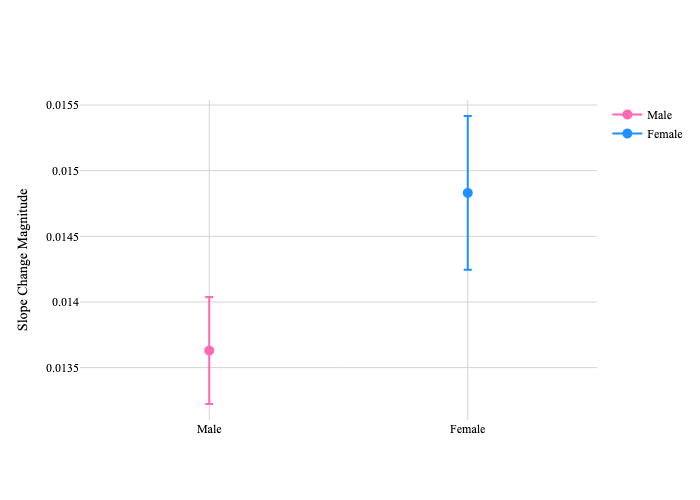

In [90]:
# Create a Plotly figure
fig = go.Figure()

genders = ['Male', 'Female']
colors= ['#FF69B4', '#1E90FF']

for gender, color in zip(genders, colors):
    prop_data = locals()[f'prop_{gender.lower()}']  # Access the variable dynamically
    fig.add_trace(go.Scatter(
        x=[gender],
        y=[prop_data['proportion']],
        error_y=dict(type='data', array=[prop_data['proportion'] - prop_data['ci_lower'], prop_data['ci_upper'] - prop_data['proportion']]),
        mode='markers+lines',
        name=gender,
        marker=dict(color=color, size=10)
    ))

# Update layout for better visualization
fig.update_layout(
    yaxis=dict(title='Slope Change Magnitude'),
    # title='Variation magnitude per gender'
)

# Update layout to adjust the range of the x-axis
fig.update_layout(
    xaxis=dict(range=[-0.5, len(genders) - 0.5]),  # Adjust the range based on your data
)
fig.update_yaxes(title_standoff=10)

# Show the plot
fig.show(renderer="png")

# Export to html
fig.write_html('q5_slope_change_per_gender.html', include_plotlyjs="cdn", config={'displayModeBar': False})

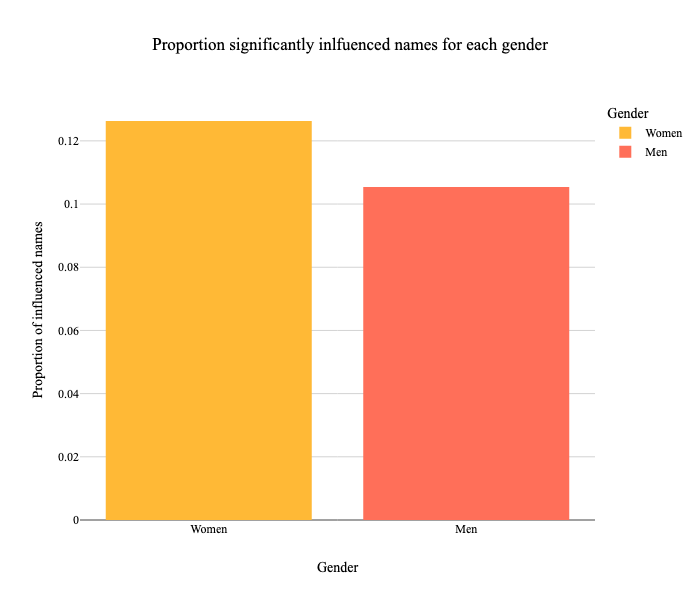

In [91]:
name_by_movie_aggregate_df_cleaned = name_by_movie_aggregate_df.dropna(subset=['gender','p_value'])

# Calculate proportion of women and men with p_value < 0.05
proportion_women = len(name_by_movie_aggregate_df_cleaned[(name_by_movie_aggregate_df_cleaned['gender'] == 'F') & (name_by_movie_aggregate_df_cleaned['p_value'] < 0.05)]) / len(name_by_movie_aggregate_df_cleaned[name_by_movie_aggregate_df_cleaned['gender'] == 'F'])
proportion_men = len(name_by_movie_aggregate_df_cleaned[(name_by_movie_aggregate_df_cleaned['gender'] == 'M') & (name_by_movie_aggregate_df_cleaned['p_value'] < 0.05)]) / len(name_by_movie_aggregate_df_cleaned[name_by_movie_aggregate_df_cleaned['gender'] == 'M'])

# Create a DataFrame with the proportions
proportions_data = {
    'Gender': ['Women', 'Men'],
    'Proportion': [proportion_women, proportion_men]
}

proportions_df = pd.DataFrame(proportions_data)

# Plotting with Plotly
fig = px.bar(proportions_df, x='Gender', y='Proportion', color='Gender',
             labels={'Proportion': 'Proportion of influenced names', 'Gender': 'Gender'},
             title='Proportion significantly inlfuenced names for each gender',
             height=600)


fig.show(renderer="png")